## **GloVe Pretrained Embeddings for Movie Text Prediction**

In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv('movies.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

## **Task 1 - Data Preparation**

In [4]:
df = df[['genres', 'overview', 'tagline', 'keywords','vote_average']]

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to text columns
df['overview_processed'] = df['overview'].apply(preprocess_text)
df['tagline_processed'] = df['tagline'].apply(preprocess_text)
df['keywords_processed'] = df['keywords'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Deep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Task 2 - GloVe Embedding Pipeline**

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load GloVe embeddings
glove_embeddings = {}
with open('glove_100.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        if len(values) < 101:  # Skip lines that don't have enough values (word + 100 dimensions)
            continue
        word = values[0]
        try:
            vector = np.array(values[1:], dtype='float32')
            glove_embeddings[word] = vector
        except ValueError:
            continue  # Skip lines with invalid float values

# Function to get embedding for a text (average of word embeddings)
def get_text_embedding(text, embeddings, embedding_dim=100):
    words = text.split()
    word_vectors = [embeddings[word] for word in words if word in embeddings]
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(word_vectors, axis=0)

# Convert processed columns to embeddings
df['overview_embedding'] = df['overview_processed'].apply(lambda x: get_text_embedding(x, glove_embeddings))
df['tagline_embedding'] = df['tagline_processed'].apply(lambda x: get_text_embedding(x, glove_embeddings))
df['keywords_embedding'] = df['keywords_processed'].apply(lambda x: get_text_embedding(x, glove_embeddings))
# Build TF-IDF on all processed text
corpus = (
    df['overview_processed'].fillna('') + ' ' +
    df['tagline_processed'].fillna('') + ' ' +
    df['keywords_processed'].fillna('')
).tolist()

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(corpus)
tfidf_vocab = tfidf.vocabulary_

# TF-IDF-weighted embedding
def get_tfidf_glove_embedding(text, embeddings, tfidf_vec, vocab, embedding_dim=100):
    words = text.split()
    if not words:
        return np.zeros(embedding_dim)
    vec = np.zeros(embedding_dim)
    total_weight = 0.0
    for w in words:
        if w in embeddings and w in vocab:
            weight = tfidf_vec[0, vocab[w]]
            if weight > 0:
                vec += embeddings[w] * weight
                total_weight += weight
    if total_weight == 0:
        return np.zeros(embedding_dim)
    return vec / total_weight

# Create TF-IDF-weighted embeddings
df['overview_tfidf_glove_embedding'] = df['overview_processed'].apply(
    lambda x: get_tfidf_glove_embedding(x, glove_embeddings, tfidf.transform([x]), tfidf_vocab)
)
df['tagline_tfidf_glove_embedding'] = df['tagline_processed'].apply(
    lambda x: get_tfidf_glove_embedding(x, glove_embeddings, tfidf.transform([x]), tfidf_vocab)
)
df['keywords_tfidf_glove_embedding'] = df['keywords_processed'].apply(
    lambda x: get_tfidf_glove_embedding(x, glove_embeddings, tfidf.transform([x]), tfidf_vocab)
)

In [8]:
from collections import Counter

# Get all unique words from processed text columns
all_words = (
    ' '.join(df['overview_processed'].fillna('')) + ' ' +
    ' '.join(df['tagline_processed'].fillna('')) + ' ' +
    ' '.join(df['keywords_processed'].fillna(''))
).split()

word_counts = Counter(all_words)

# Calculate embedding coverage
total_unique_tokens = len(word_counts)
covered_tokens = sum(1 for word in word_counts if word in glove_embeddings)
coverage_percentage = (covered_tokens / total_unique_tokens) * 100

print(f"Embedding Coverage Report")
print(f"=" * 50)
print(f"Total unique tokens in dataset: {total_unique_tokens}")
print(f"Tokens covered by GloVe: {covered_tokens}")
print(f"Coverage percentage: {coverage_percentage:.2f}%")
print(f"Uncovered tokens: {total_unique_tokens - covered_tokens}")

Embedding Coverage Report
Total unique tokens in dataset: 24545
Tokens covered by GloVe: 22503
Coverage percentage: 91.68%
Uncovered tokens: 2042


## **Task 3 - Model A: Rating Prediction (Regression)**

In [10]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Define neural network
class VotePredictor(nn.Module):
    def __init__(self, input_dim=100):
        super(VotePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer, and move model to device
model = VotePredictor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


### Model of: Rating Prediction using Overview Embeddings

In [45]:
# Convert embeddings to numpy arrays
X = np.array([embedding for embedding in df['overview_embedding']])
y = df['vote_average'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model with correct input dimension (100 for embedding dimension)
model = VotePredictor(input_dim=100).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store losses
train_losses = []
test_losses = []

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train MSE Loss: {avg_train_loss:.4f}, Train RMSE Loss: {np.sqrt(avg_train_loss):.4f}, Test MSE Loss: {test_loss.item():.4f}, Test RMSE Loss: {np.sqrt(test_loss.item()):.4f}")

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

Epoch 10/50, Train MSE Loss: 1.3394, Train RMSE Loss: 1.1573, Test MSE Loss: 1.5425, Test RMSE Loss: 1.2420
Epoch 20/50, Train MSE Loss: 1.2190, Train RMSE Loss: 1.1041, Test MSE Loss: 1.6248, Test RMSE Loss: 1.2747
Epoch 30/50, Train MSE Loss: 1.1657, Train RMSE Loss: 1.0797, Test MSE Loss: 1.5929, Test RMSE Loss: 1.2621
Epoch 40/50, Train MSE Loss: 1.0782, Train RMSE Loss: 1.0383, Test MSE Loss: 1.6489, Test RMSE Loss: 1.2841
Epoch 50/50, Train MSE Loss: 1.0053, Train RMSE Loss: 1.0027, Test MSE Loss: 1.7133, Test RMSE Loss: 1.3089

Final Train Loss: 1.0053
Final Test Loss: 1.7133


In [46]:
import matplotlib.pyplot as plt

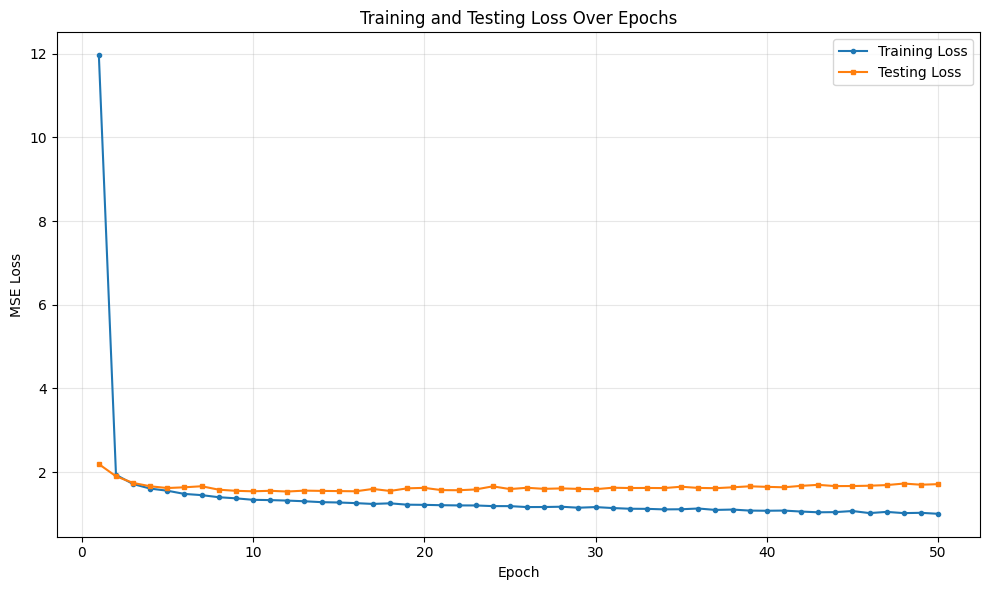


Final Train Loss: 1.0053
Final Test Loss: 1.7133


In [47]:
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', markersize=3)
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

### Model of: Rating Prediction using Tagline Embeddings

In [49]:
# Convert embeddings to numpy arrays
X = np.array([embedding for embedding in df['tagline_embedding']])
y = df['vote_average'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model with correct input dimension (100 for embedding dimension)
model = VotePredictor(input_dim=100).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store losses
train_losses = []
test_losses = []

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train MSE Loss: {avg_train_loss:.4f}, Train RMSE Loss: {np.sqrt(avg_train_loss):.4f}, Test MSE Loss: {test_loss.item():.4f}, Test RMSE Loss: {np.sqrt(test_loss.item()):.4f}")

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

Epoch 10/50, Train MSE Loss: 1.3110, Train RMSE Loss: 1.1450, Test MSE Loss: 1.5441, Test RMSE Loss: 1.2426
Epoch 20/50, Train MSE Loss: 1.2189, Train RMSE Loss: 1.1040, Test MSE Loss: 1.6010, Test RMSE Loss: 1.2653
Epoch 30/50, Train MSE Loss: 1.1209, Train RMSE Loss: 1.0587, Test MSE Loss: 1.7073, Test RMSE Loss: 1.3067
Epoch 40/50, Train MSE Loss: 1.0630, Train RMSE Loss: 1.0310, Test MSE Loss: 1.7913, Test RMSE Loss: 1.3384
Epoch 50/50, Train MSE Loss: 1.0084, Train RMSE Loss: 1.0042, Test MSE Loss: 1.7722, Test RMSE Loss: 1.3312

Final Train Loss: 1.0084
Final Test Loss: 1.7722


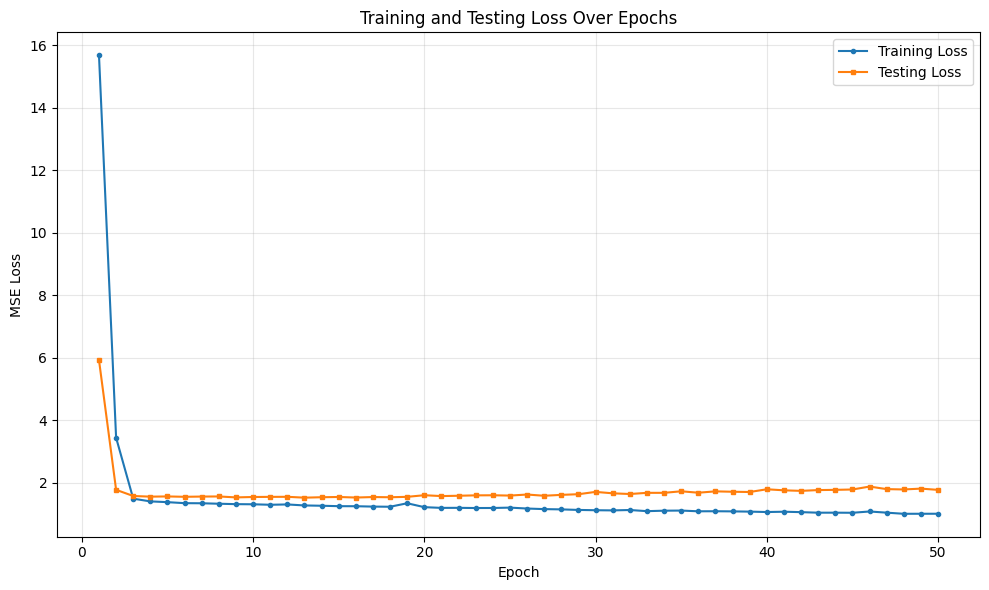


Final Train Loss: 1.0084
Final Test Loss: 1.7722


In [50]:
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', markersize=3)
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

## **Task 4 - Model B: Genre Prediction (Multi-Label Classification)**

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

# Parse genres (multiple labels separated by space or pipe)
def parse_genres(genre_string):
    if pd.isna(genre_string):
        return []
    return [g.strip() for g in str(genre_string).split(' ')]

# Get all unique genres
all_genres = set()
for genres in df['genres']:
    all_genres.update(parse_genres(genres))

all_genres = sorted(list(all_genres))
print(f"Total unique genres: {len(all_genres)}")
print(f"Genres: {all_genres}")

# Create multi-label encoder
mlb = MultiLabelBinarizer(classes=all_genres)
genre_labels = mlb.fit_transform([parse_genres(g) for g in df['genres']])

Total unique genres: 22
Genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'Foreign', 'History', 'Horror', 'Movie', 'Music', 'Mystery', 'Romance', 'Science', 'TV', 'Thriller', 'War', 'Western']


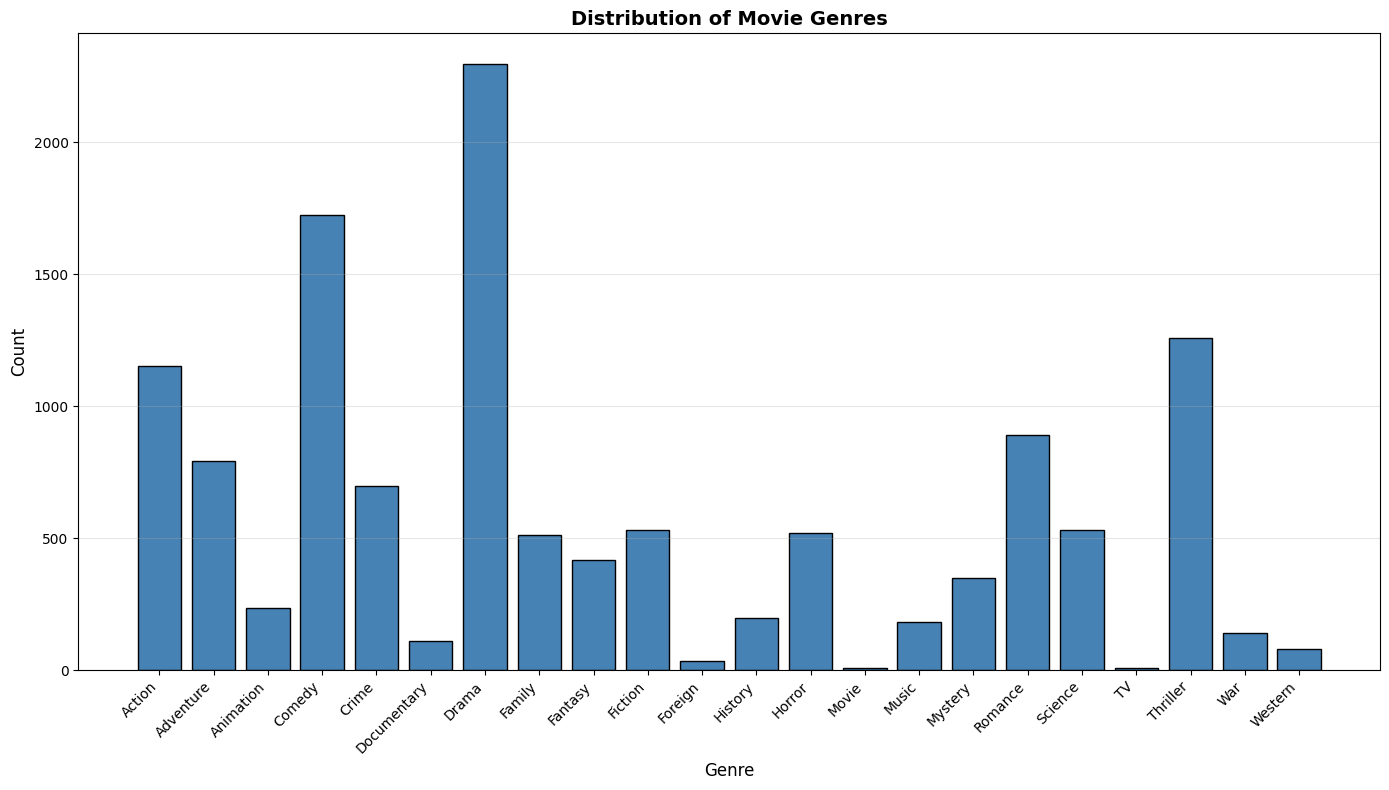


Genre Counts:
Drama               :  2297
Comedy              :  1722
Thriller            :  1259
Action              :  1153
Romance             :   890
Adventure           :   790
Crime               :   696
Fiction             :   530
Science             :   530
Horror              :   519
Family              :   510
Fantasy             :   418
Mystery             :   347
Animation           :   234
History             :   197
Music               :   183
War                 :   142
Documentary         :   110
Western             :    80
Foreign             :    34
Movie               :     8
TV                  :     8


In [51]:
# Count the frequency of each genre
genre_counts = {}
for genre in all_genres:
    genre_counts[genre] = sum([parse_genres(g).count(genre) for g in df['genres']])

# Create a bar plot
plt.figure(figsize=(14, 8))
plt.bar(genre_counts.keys(), genre_counts.values(), color='steelblue', edgecolor='black')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Movie Genres', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print genre counts
print("\nGenre Counts:")
print("=" * 40)
for genre, count in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{genre:20s}: {count:5d}")

In [52]:
# Combine overview embeddings with genre targets
from sklearn.metrics import f1_score
# Define multi-label classification network
class GenreClassifier(nn.Module):
    def __init__(self, input_dim=100, num_genres=len(all_genres)):
        super(GenreClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_genres)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Model of: Genre Prediction using Overview Embeddings

In [57]:
X = np.array([embedding for embedding in df['overview_embedding']])
y = torch.tensor(genre_labels, dtype=torch.float32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, genre_labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model and training components
genre_model = GenreClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(genre_model.parameters(), lr=0.001)

# Initialize lists to store losses
train_losses = []
test_losses = []

# Train the model
epochs = 50
for epoch in range(epochs):
    genre_model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = genre_model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    genre_model.eval()
    with torch.no_grad():
        test_predictions = genre_model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {((predictions > 0).float() == batch_y).float().mean().item():.4f}, Micro F1 Score: {f1_score(batch_y.cpu(), (predictions > 0).float().cpu(), average='micro'):.4f}, Macro F1 Score: {f1_score(batch_y.cpu(), (predictions > 0).float().cpu(), average='macro'):.4f}, Ham Loss: {avg_train_loss:.4f}")

# Evaluate on test set
genre_model.eval()
with torch.no_grad():
    test_predictions = genre_model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f"\nTest Loss: {test_loss.item():.4f}, Testing Accuracy: {((test_predictions > 0).float() == y_test_tensor).float().mean().item():.4f}, Micro F1 Score: {f1_score(y_test_tensor.cpu(), (test_predictions > 0).float().cpu(), average='micro'):.4f}, Macro F1 Score: {f1_score(y_test_tensor.cpu(), (test_predictions > 0).float().cpu(), average='macro'):.4f}, Ham Loss: {test_loss.item():.4f}")

Epoch 10/50, Training Accuracy: 0.9318, Micro F1 Score: 0.7273, Macro F1 Score: 0.1818, Ham Loss: 0.2278
Epoch 20/50, Training Accuracy: 0.8636, Micro F1 Score: 0.2500, Macro F1 Score: 0.0303, Ham Loss: 0.2136
Epoch 30/50, Training Accuracy: 0.9318, Micro F1 Score: 0.7273, Macro F1 Score: 0.1061, Ham Loss: 0.2056
Epoch 40/50, Training Accuracy: 0.9545, Micro F1 Score: 0.8333, Macro F1 Score: 0.1818, Ham Loss: 0.1988
Epoch 50/50, Training Accuracy: 0.9091, Micro F1 Score: 0.6667, Macro F1 Score: 0.1364, Ham Loss: 0.1909

Test Loss: 0.2220, Testing Accuracy: 0.9068, Micro F1 Score: 0.5509, Macro F1 Score: 0.3639, Ham Loss: 0.2220


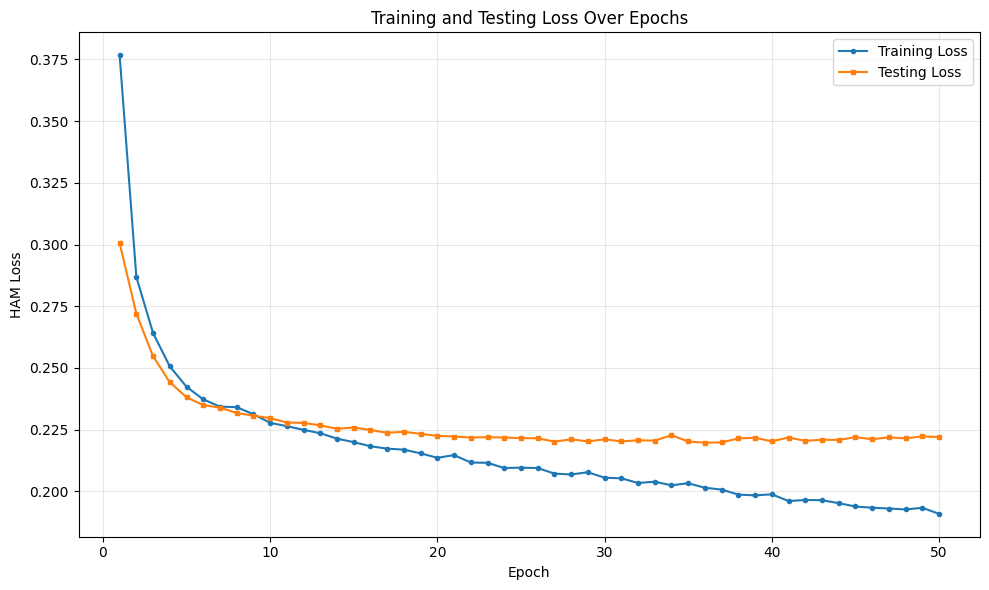


Final Train Loss: 0.1909
Final Test Loss: 0.2220


In [58]:
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', markersize=3)
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('HAM Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

### Model of: Rating Prediction using Keywords Embeddings

In [55]:
X = np.array([embedding for embedding in df['keywords_embedding']])
y = torch.tensor(genre_labels, dtype=torch.float32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, genre_labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model and training components
genre_model = GenreClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(genre_model.parameters(), lr=0.001)

# Initialize lists to store losses
train_losses = []
test_losses = []

# Train the model
epochs = 50
for epoch in range(epochs):
    genre_model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = genre_model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    genre_model.eval()
    with torch.no_grad():
        test_predictions = genre_model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {((predictions > 0).float() == batch_y).float().mean().item():.4f}, Micro F1 Score: {f1_score(batch_y.cpu(), (predictions > 0).float().cpu(), average='micro'):.4f}, Macro F1 Score: {f1_score(batch_y.cpu(), (predictions > 0).float().cpu(), average='macro'):.4f}, Ham Loss: {avg_train_loss:.4f}")

# Evaluate on test set
genre_model.eval()
with torch.no_grad():
    test_predictions = genre_model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f"\nTest Loss: {test_loss.item():.4f}, Testing Accuracy: {((test_predictions > 0).float() == y_test_tensor).float().mean().item():.4f}, Micro F1 Score: {f1_score(y_test_tensor.cpu(), (test_predictions > 0).float().cpu(), average='micro'):.4f}, Macro F1 Score: {f1_score(y_test_tensor.cpu(), (test_predictions > 0).float().cpu(), average='macro'):.4f}, Ham Loss: {test_loss.item():.4f}")

Epoch 10/50, Training Accuracy: 0.8409, Micro F1 Score: 0.2222, Macro F1 Score: 0.0303, Ham Loss: 0.2401
Epoch 20/50, Training Accuracy: 0.9318, Micro F1 Score: 0.7692, Macro F1 Score: 0.2273, Ham Loss: 0.2258
Epoch 30/50, Training Accuracy: 0.9318, Micro F1 Score: 0.5714, Macro F1 Score: 0.0758, Ham Loss: 0.2146
Epoch 40/50, Training Accuracy: 0.9091, Micro F1 Score: 0.6667, Macro F1 Score: 0.1667, Ham Loss: 0.2072
Epoch 50/50, Training Accuracy: 0.9091, Micro F1 Score: 0.3333, Macro F1 Score: 0.0455, Ham Loss: 0.2012

Test Loss: 0.2464, Testing Accuracy: 0.9010, Micro F1 Score: 0.4930, Macro F1 Score: 0.3368, Ham Loss: 0.2464


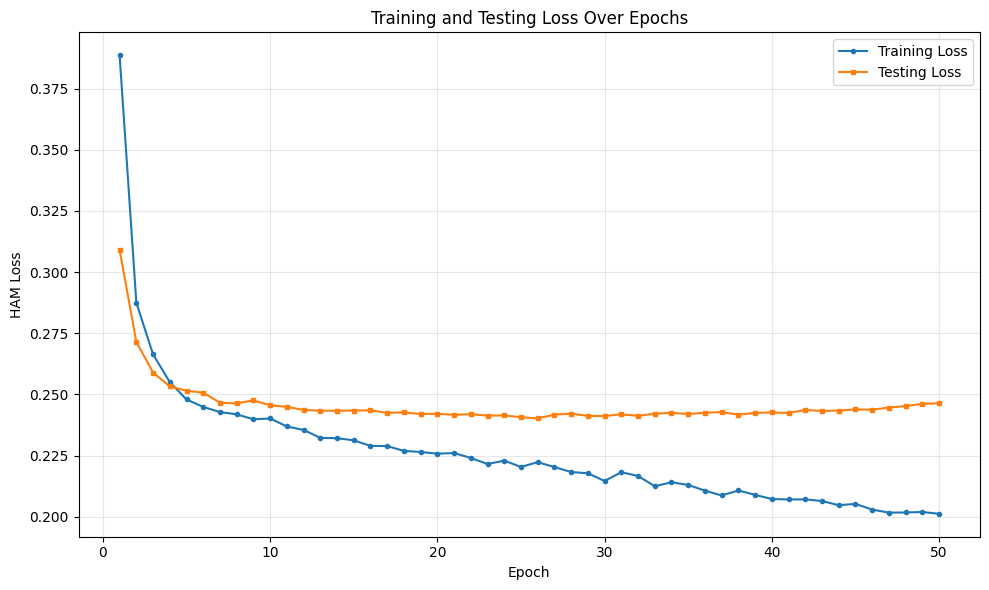


Final Train Loss: 0.2012
Final Test Loss: 0.2464


In [56]:
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', markersize=3)
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('HAM Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

## **Task 5 - Frequent Words per Genre**

In [61]:
# Function to get words from processed text
def get_words_from_text(text):
    if pd.isna(text) or text == "":
        return []
    return text.split()

# Create a dictionary to store word frequencies per genre
genre_word_freq = {}

# Iterate through each genre
for genre in all_genres:
    genre_words = []
    
    # Get all rows that belong to this genre
    for idx, row in df.iterrows():
        genres_list = parse_genres(row['genres'])
        if genre in genres_list:
            # Combine words from all text columns
            words = []
            words.extend(get_words_from_text(row['overview_processed']))
            words.extend(get_words_from_text(row['tagline_processed']))
            words.extend(get_words_from_text(row['keywords_processed']))
            genre_words.extend(words)
    
    # Count word frequencies
    word_counts = Counter(genre_words)
    genre_word_freq[genre] = word_counts


for genre in all_genres:
    word_counts = genre_word_freq[genre]
    
    # Get top 10 most frequent words
    top_10 = word_counts.most_common(10)
    
    # Get bottom 10 least frequent words (with frequency >= 3)
    filtered_words = {word: count for word, count in word_counts.items() if count >= 3}
    sorted_words = sorted(filtered_words.items(), key=lambda x: x[1])
    bottom_10 = sorted_words[:10] if len(sorted_words) >= 10 else sorted_words


GENERATING VISUALIZATIONS FOR EACH GENRE


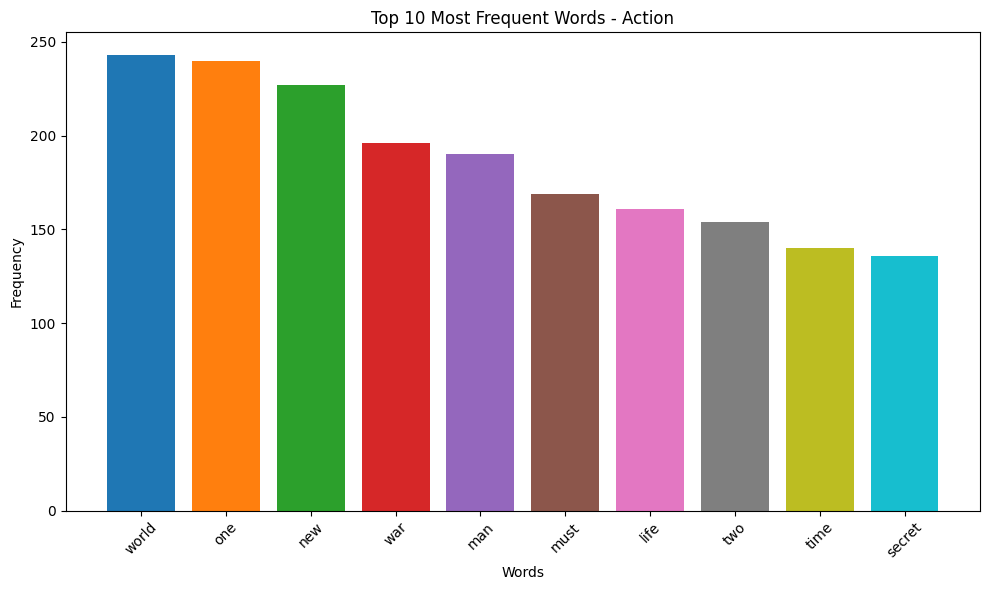

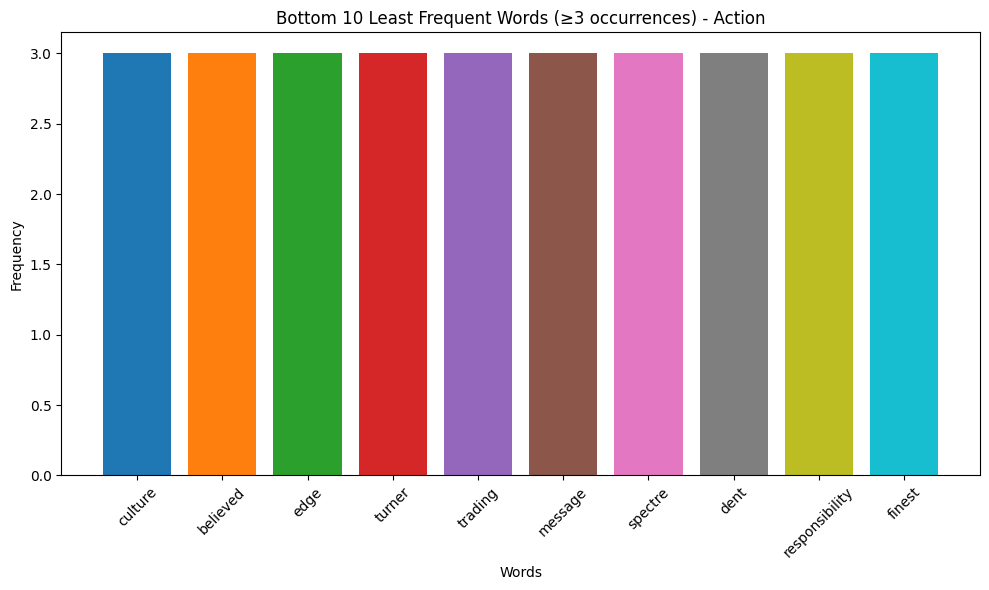

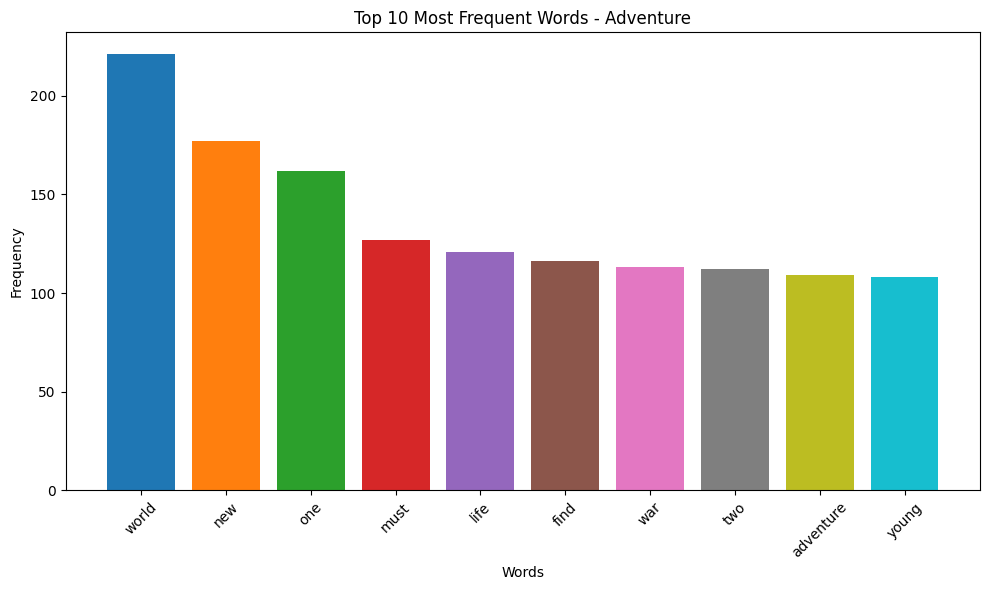

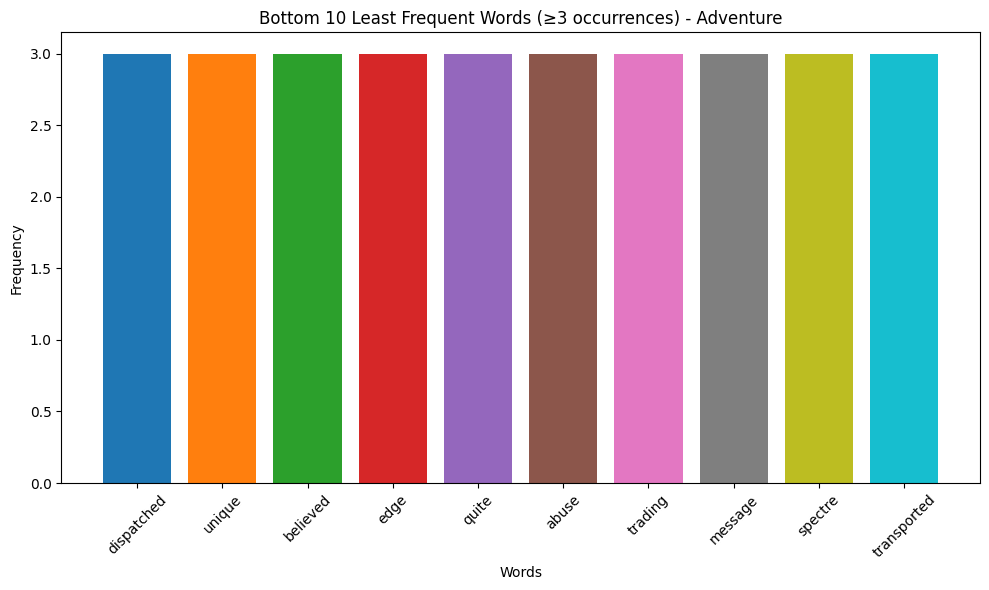

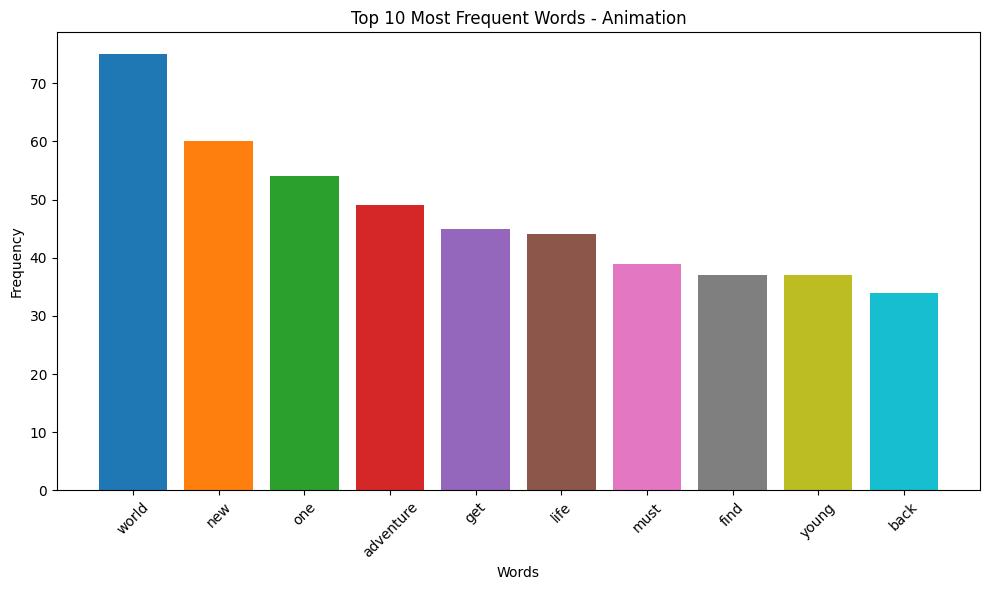

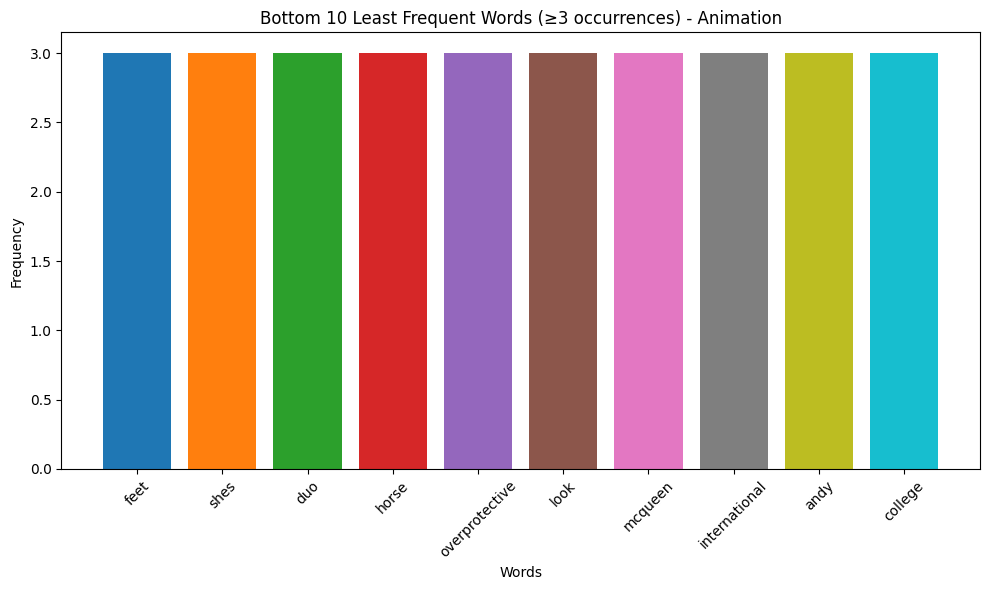

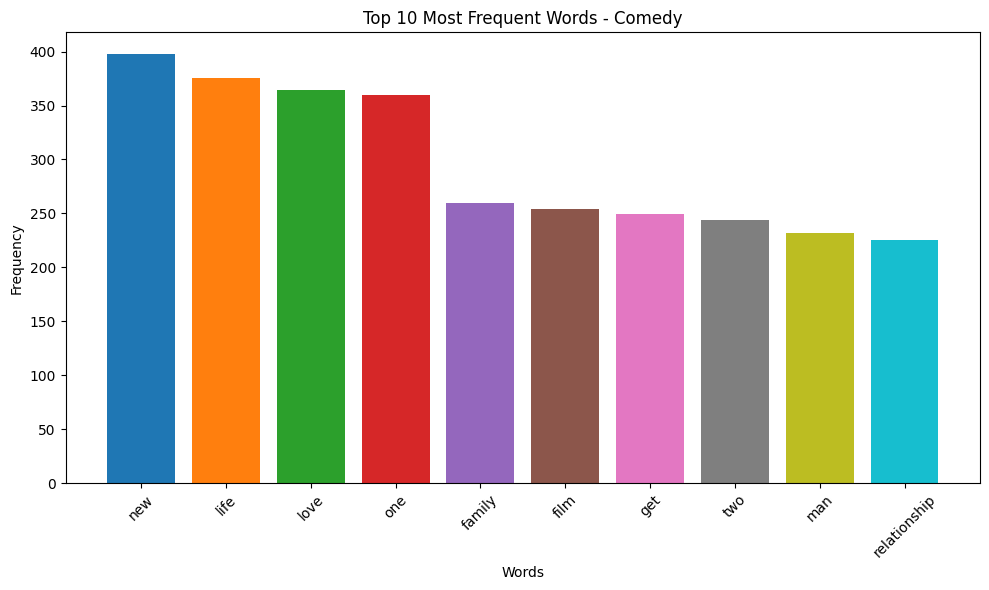

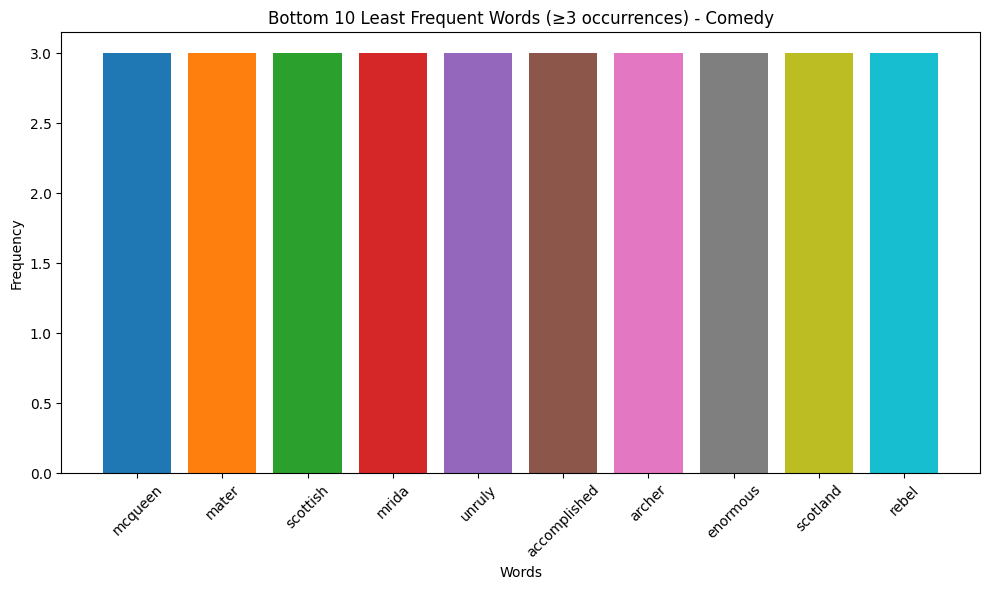

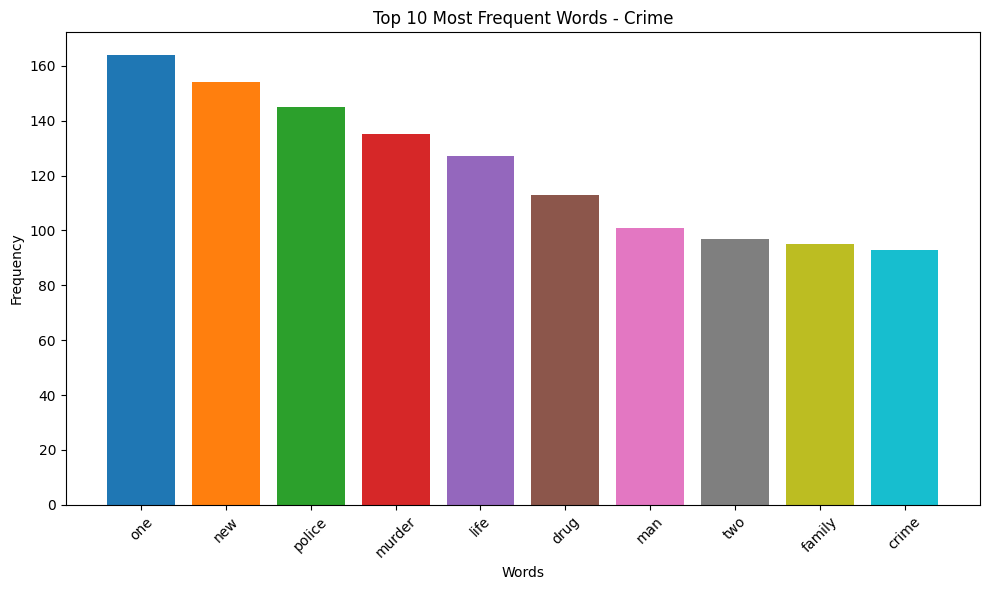

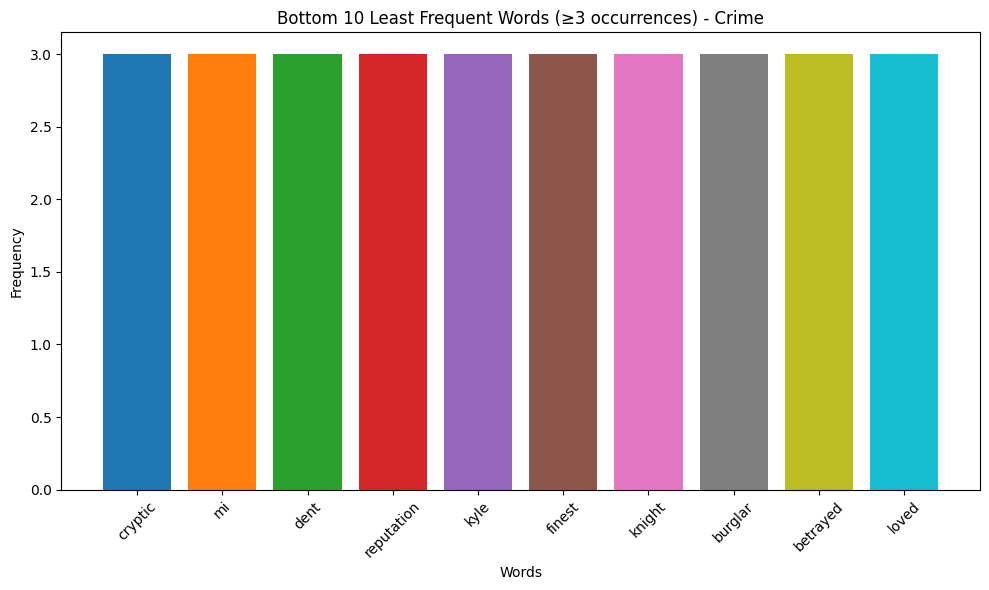

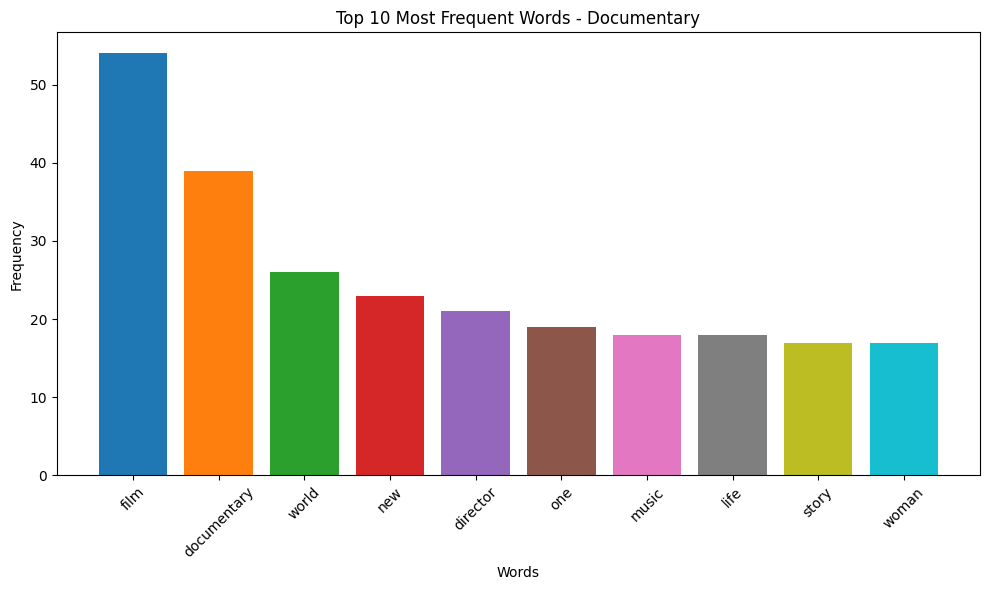

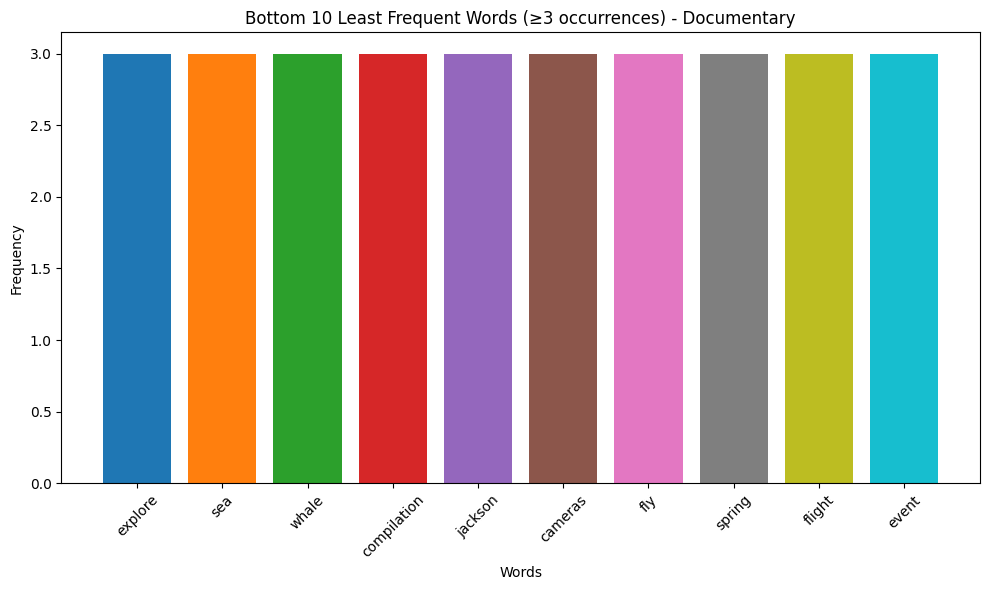

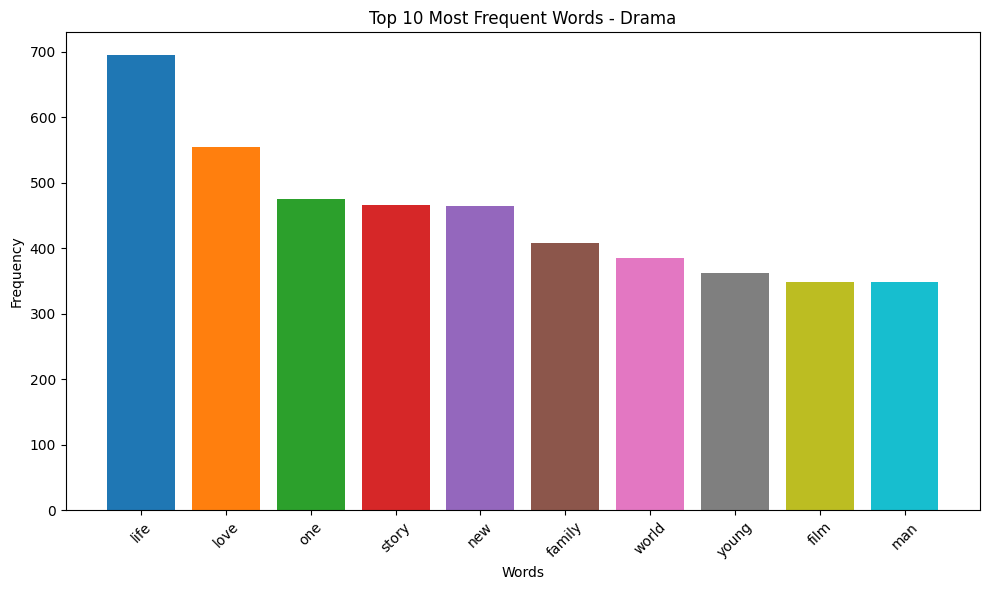

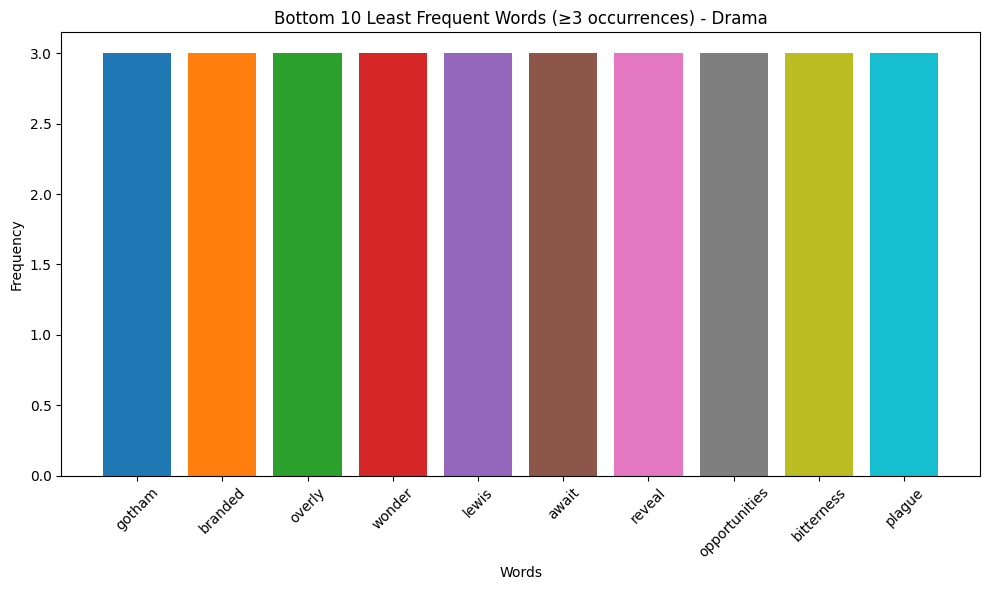

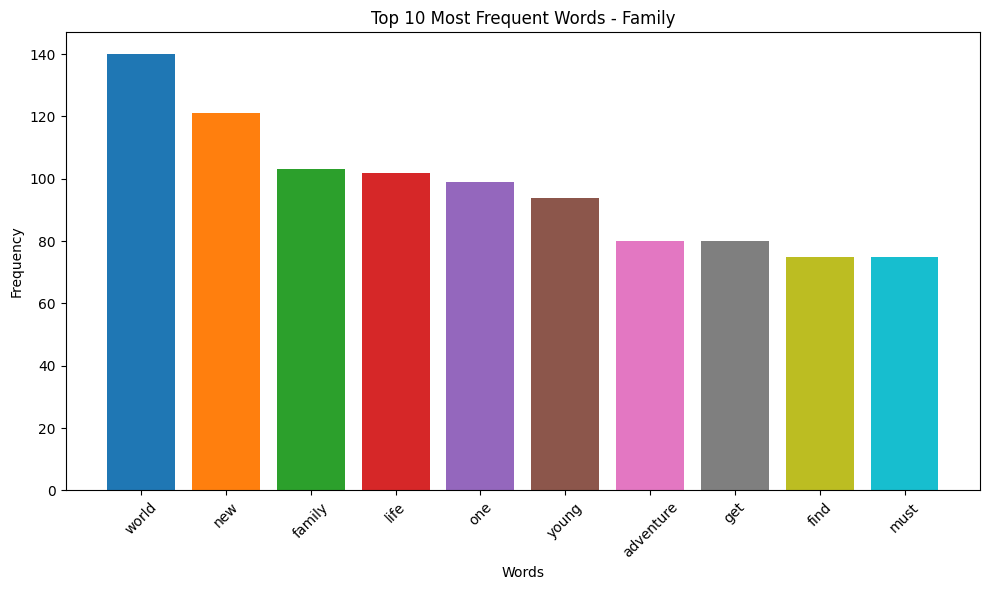

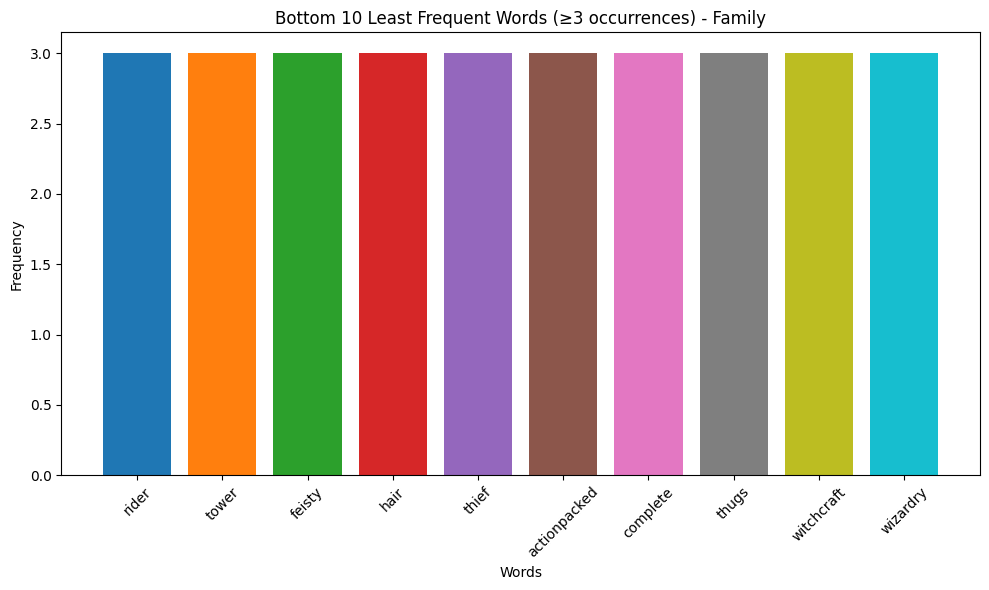

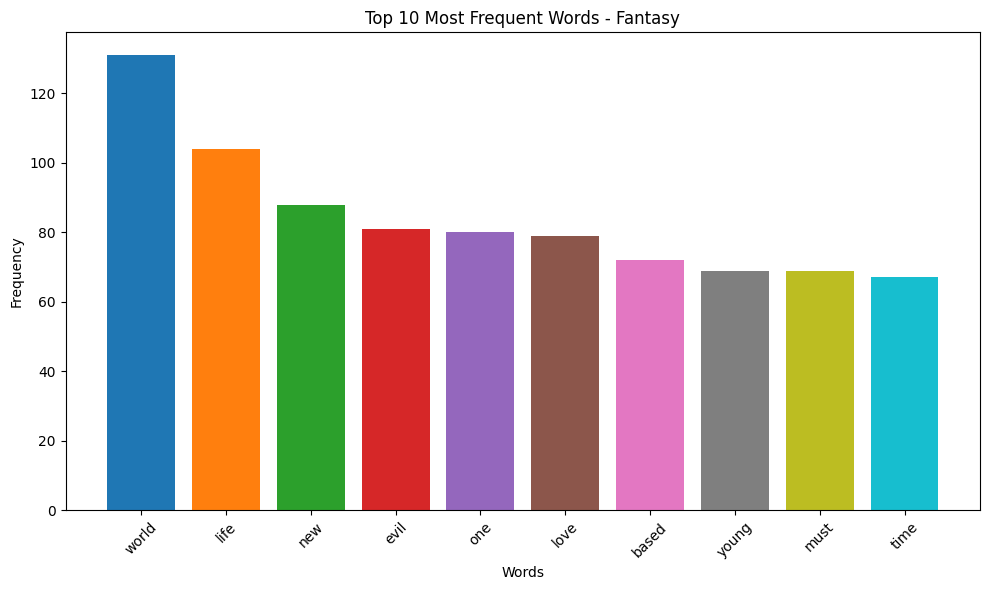

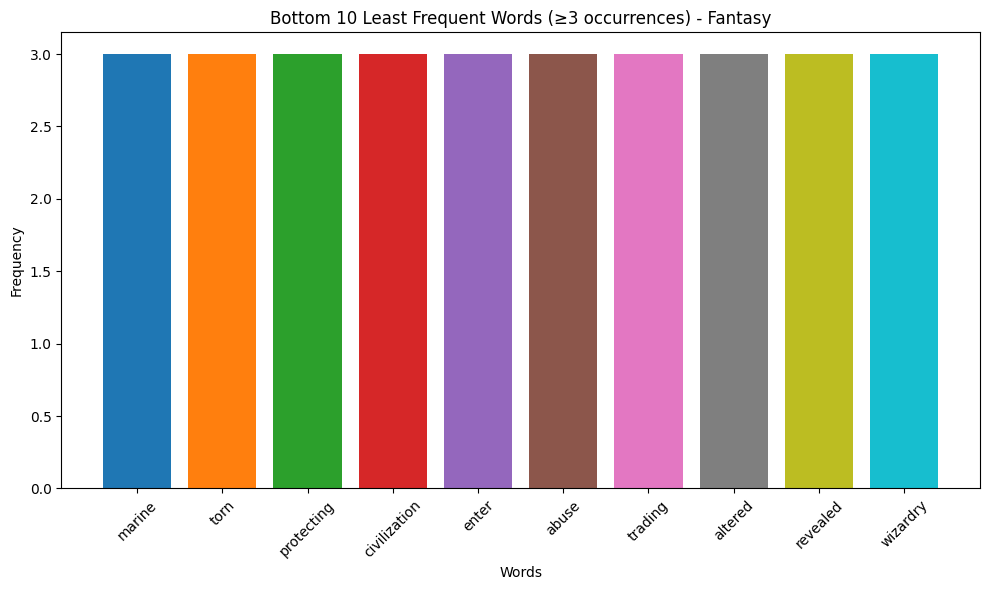

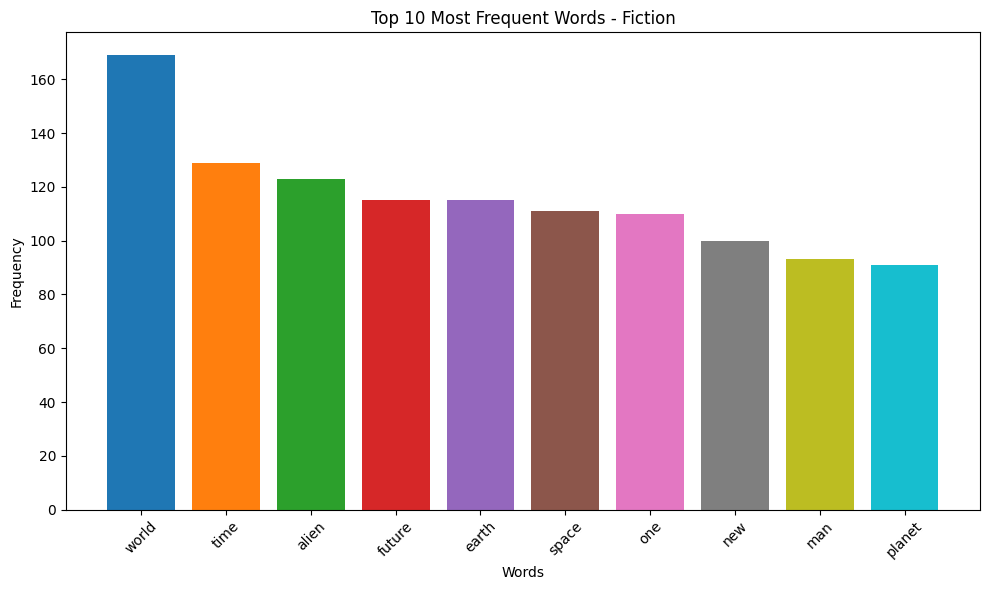

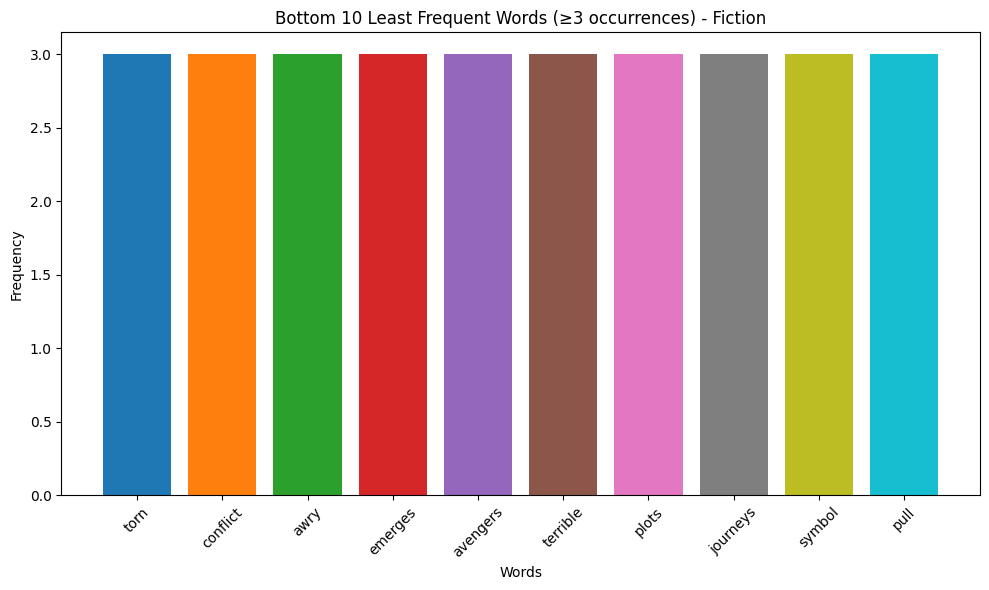

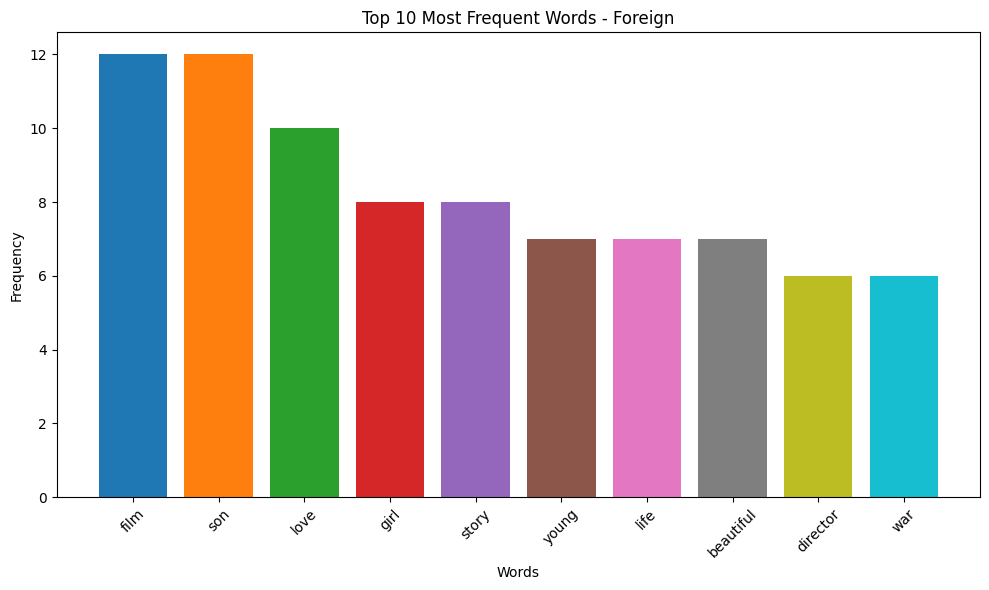

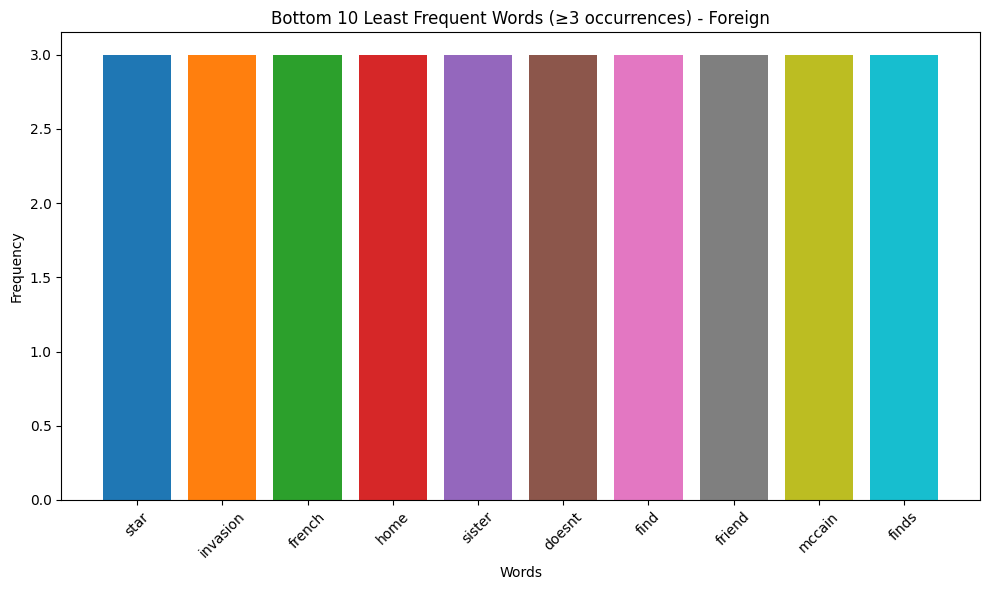

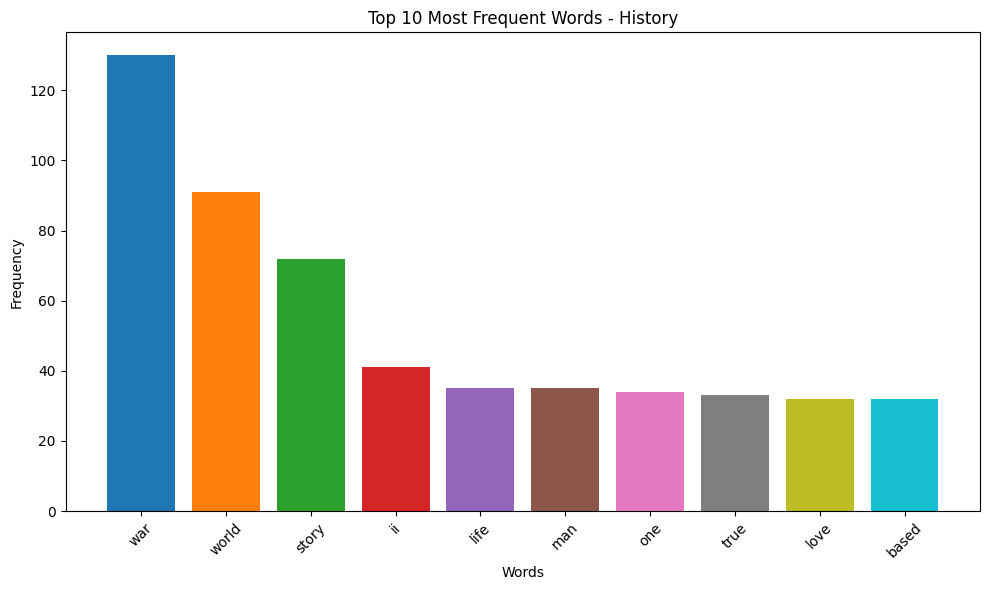

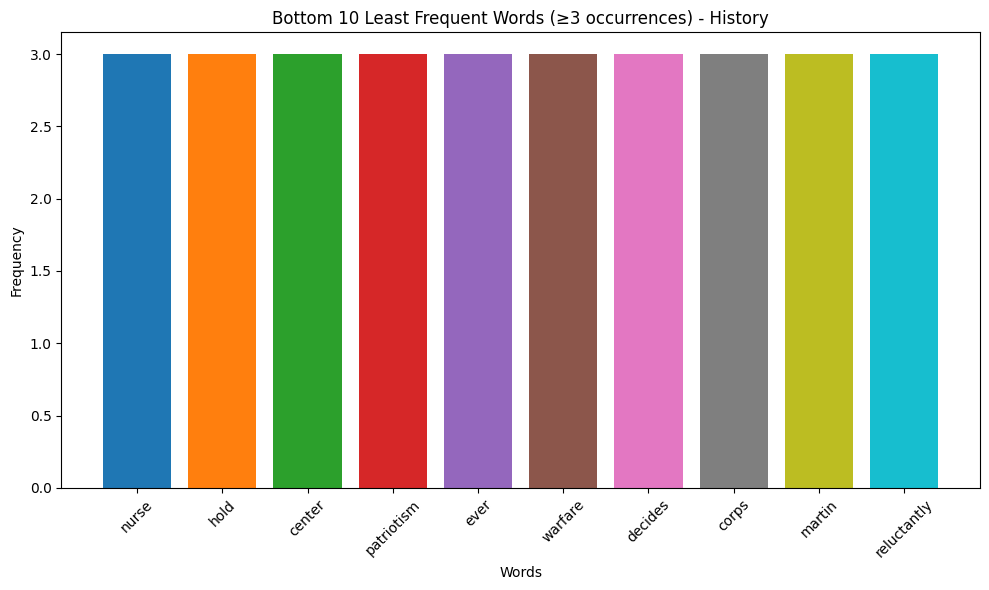

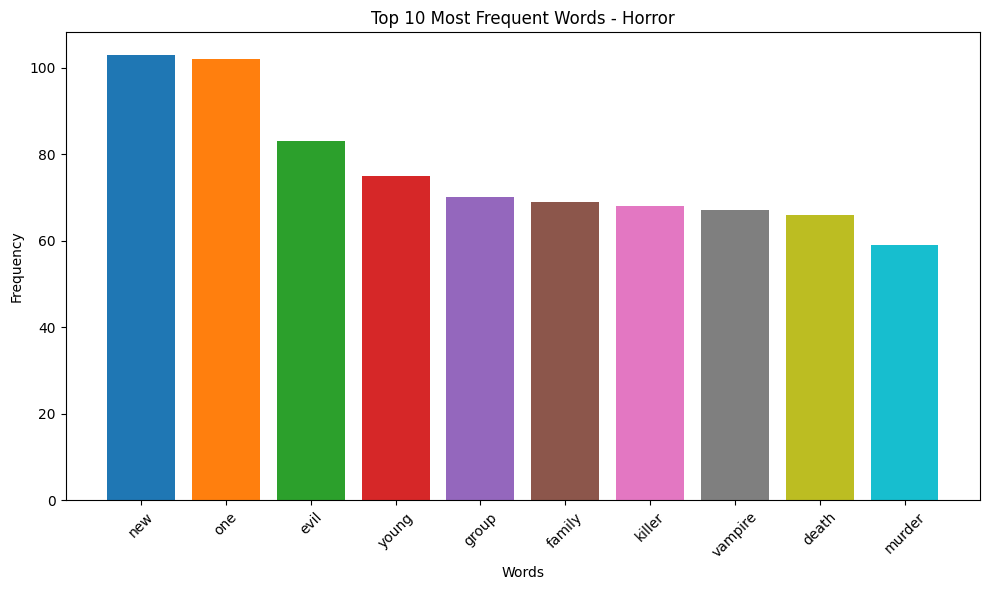

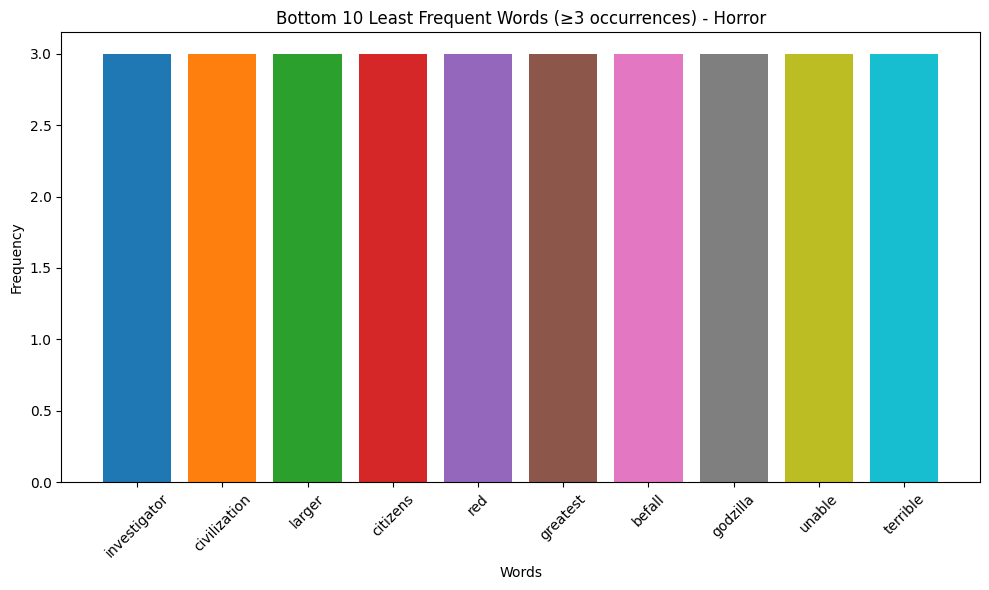

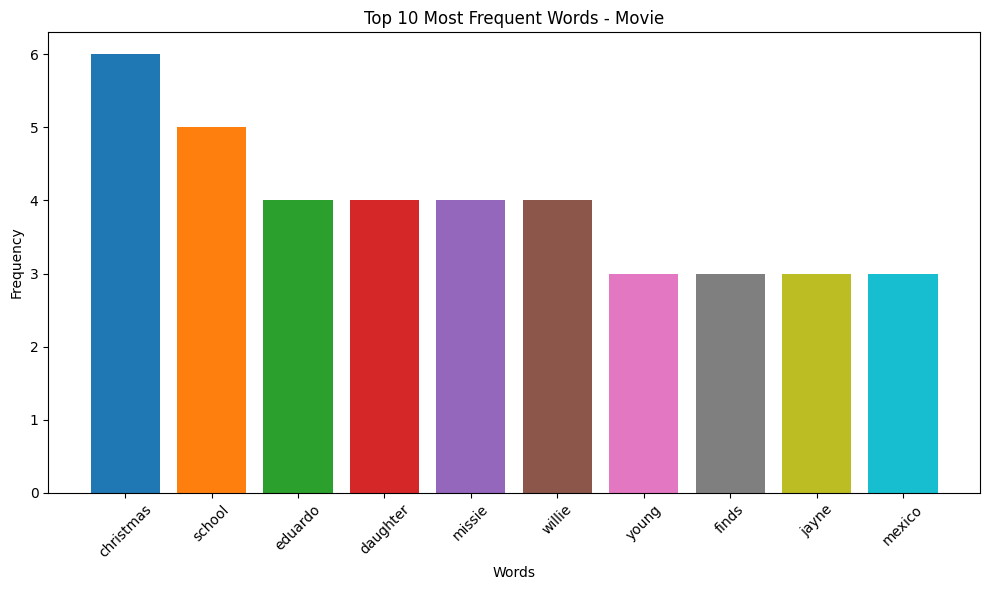

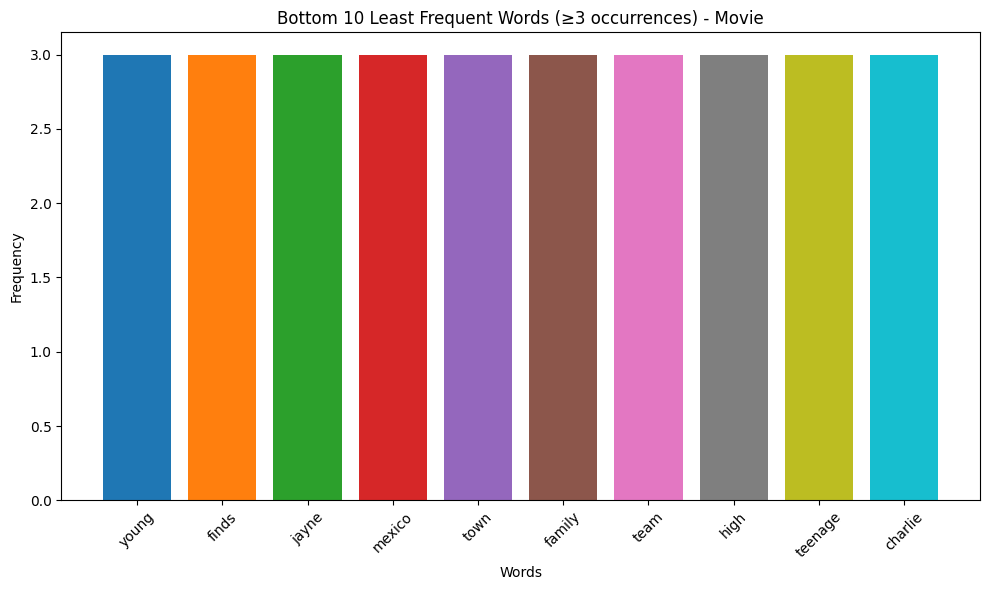

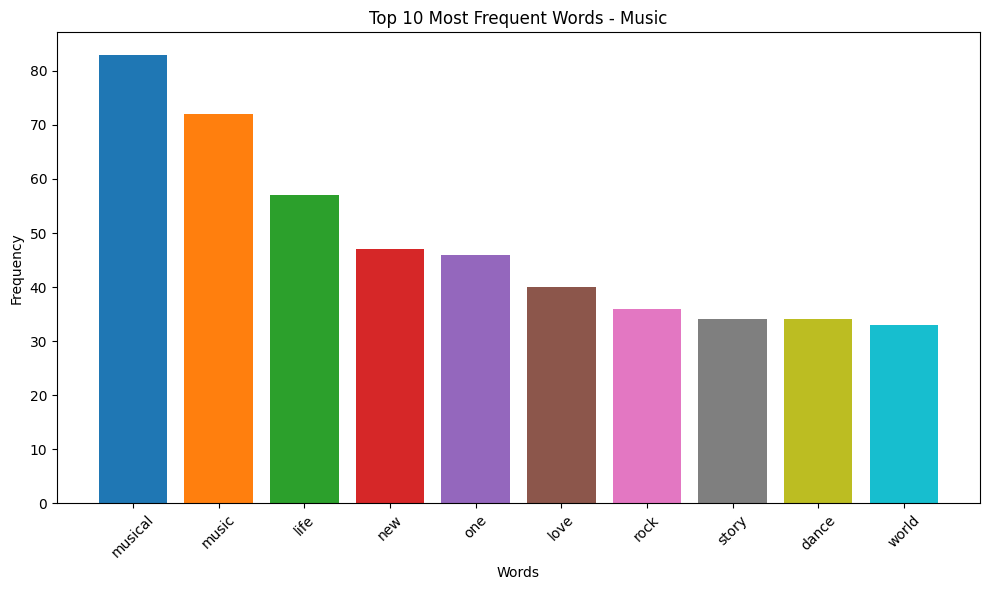

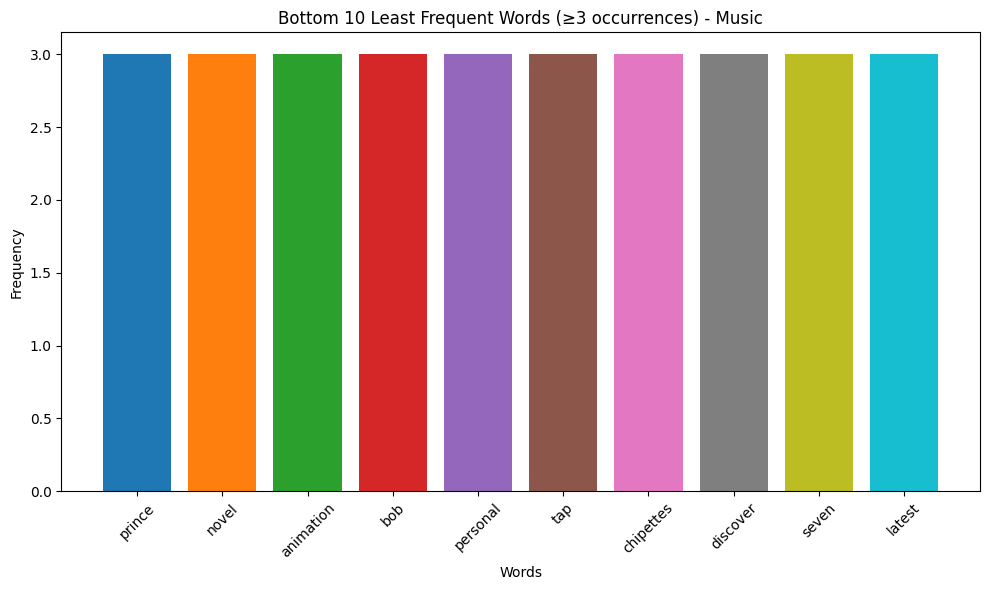

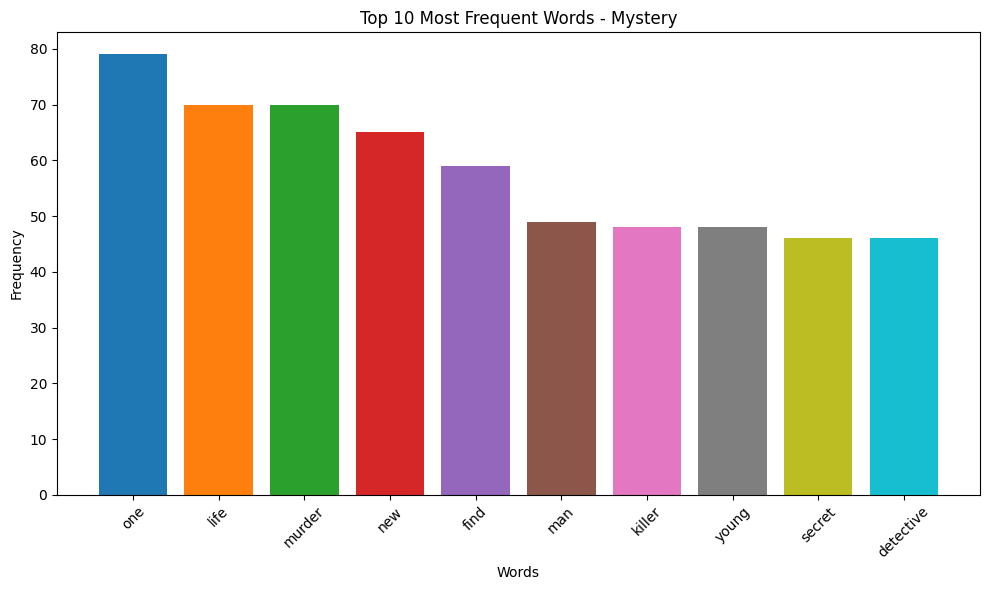

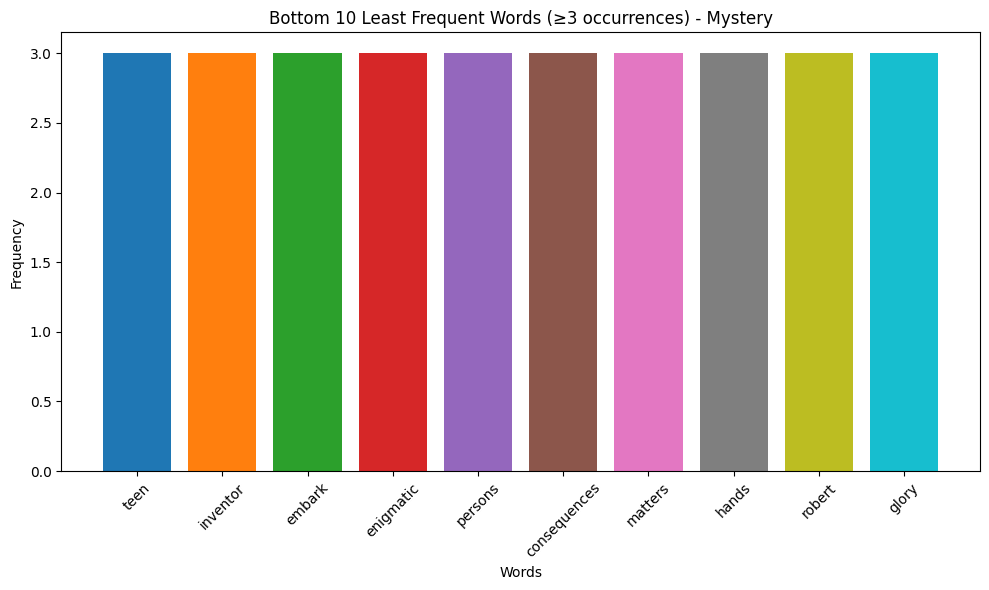

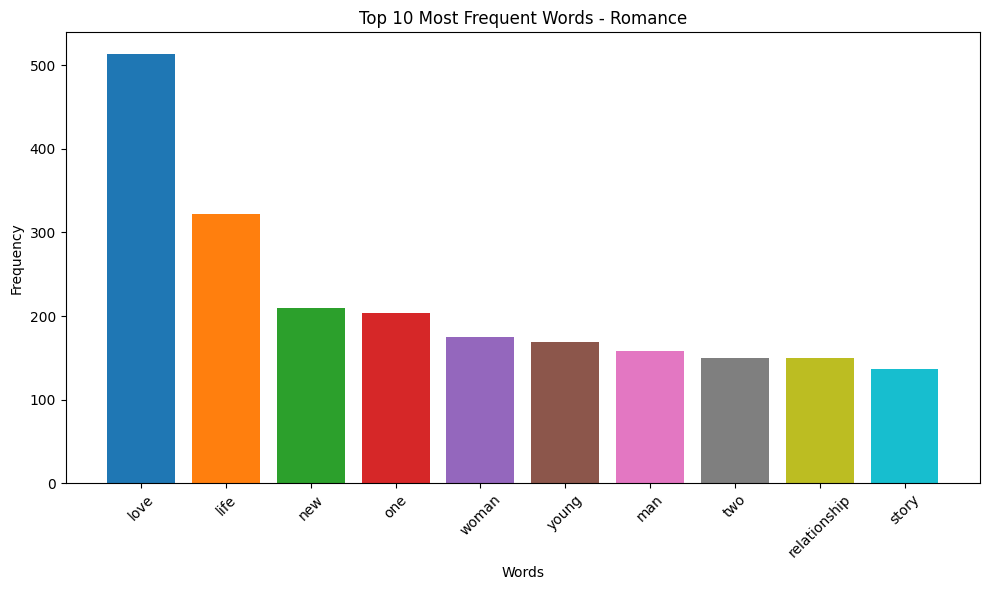

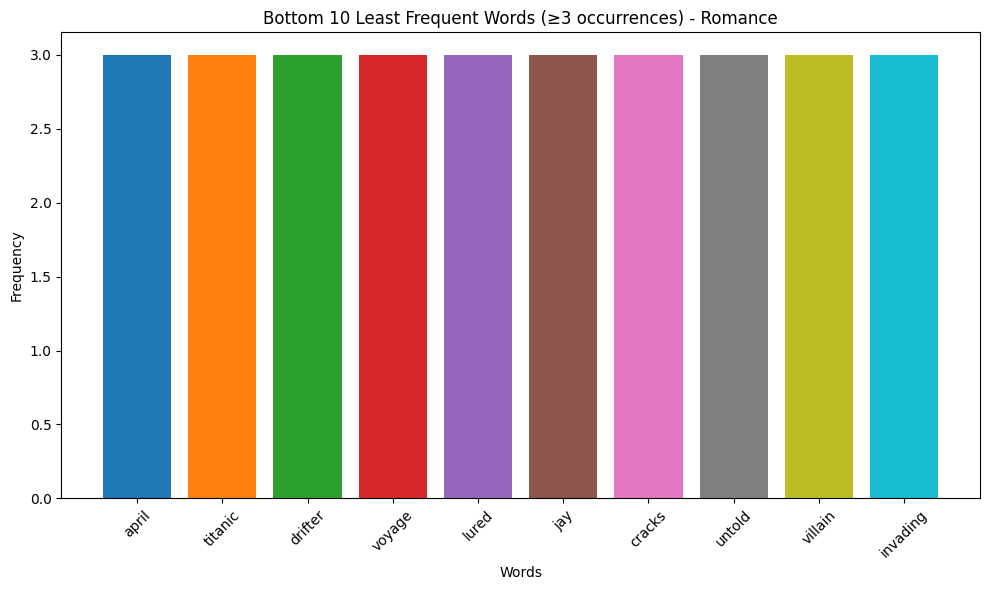

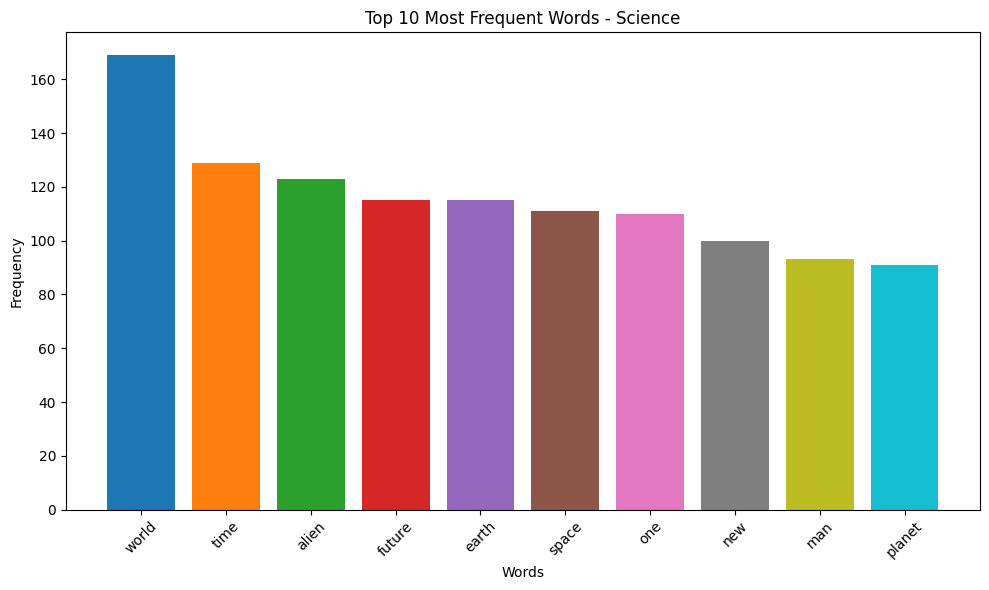

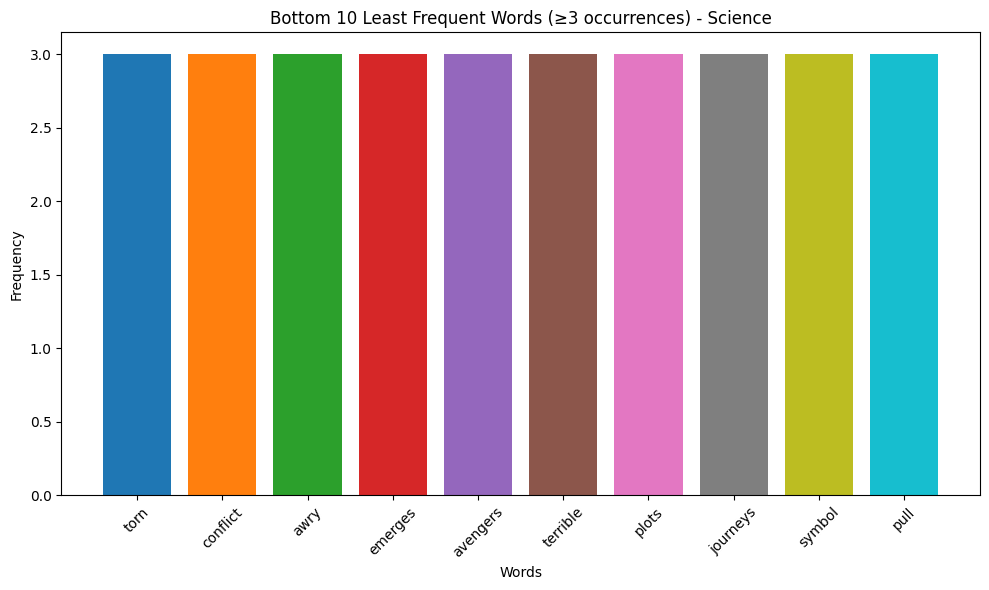

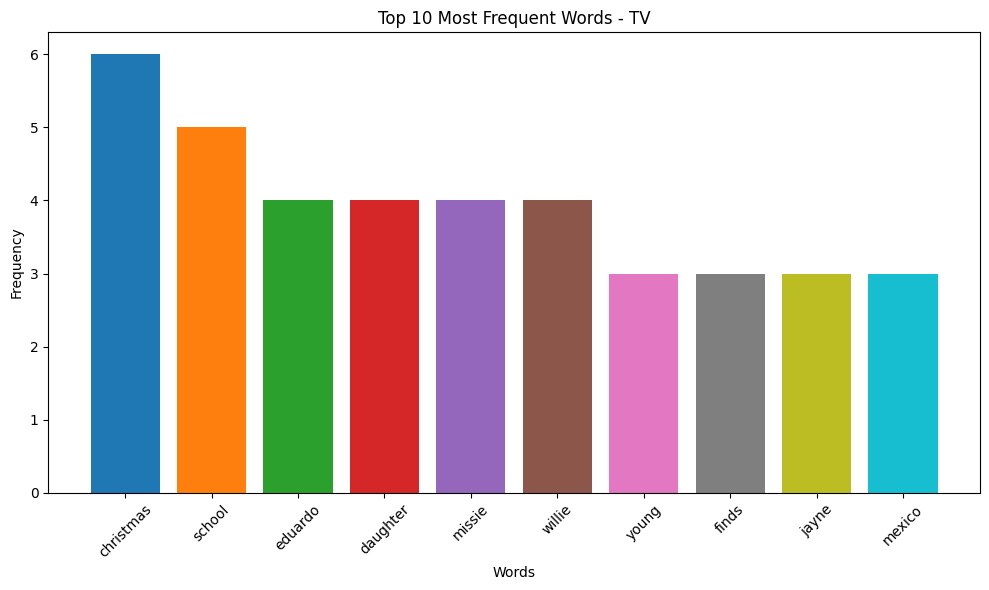

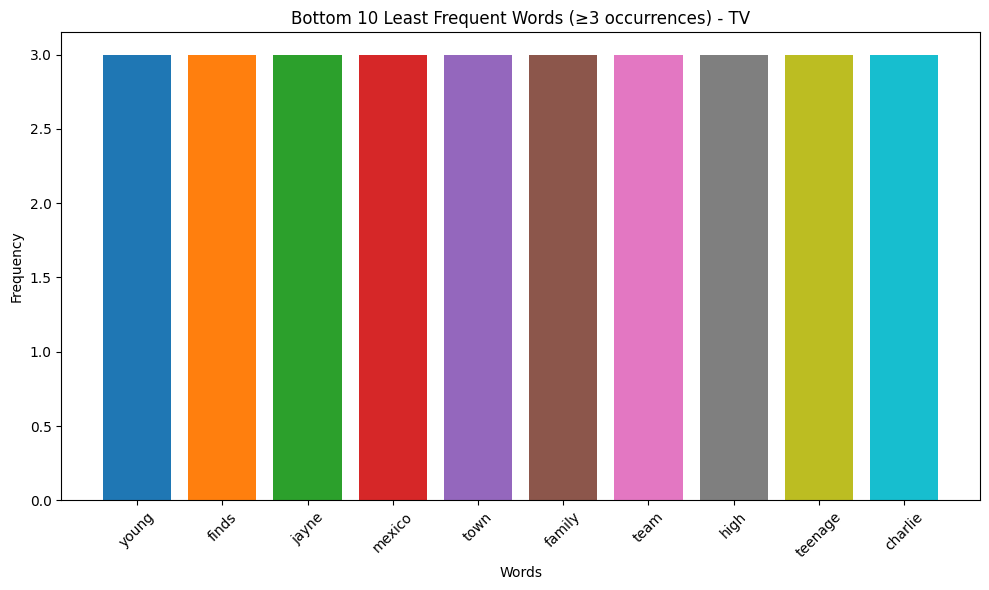

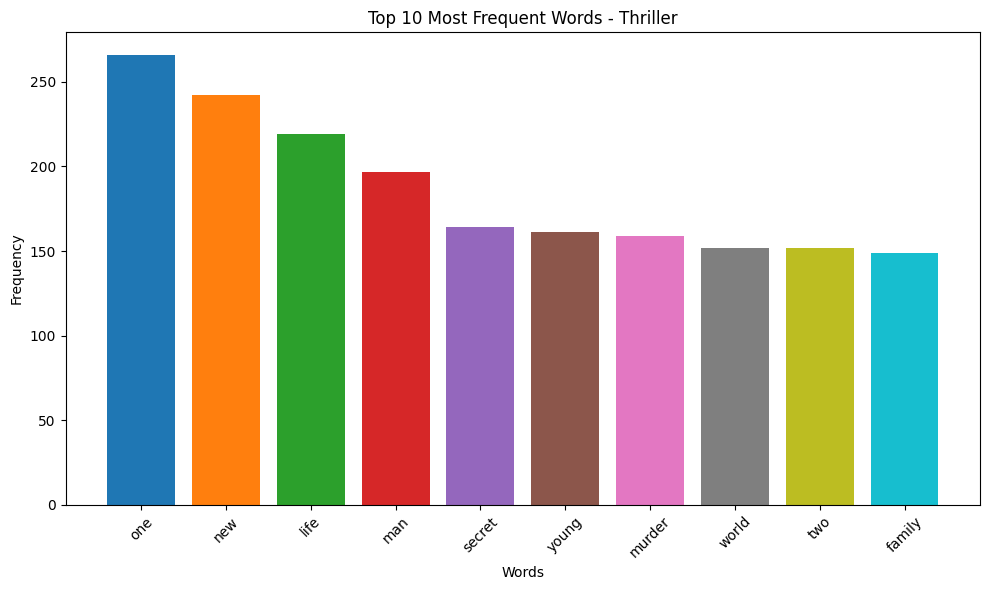

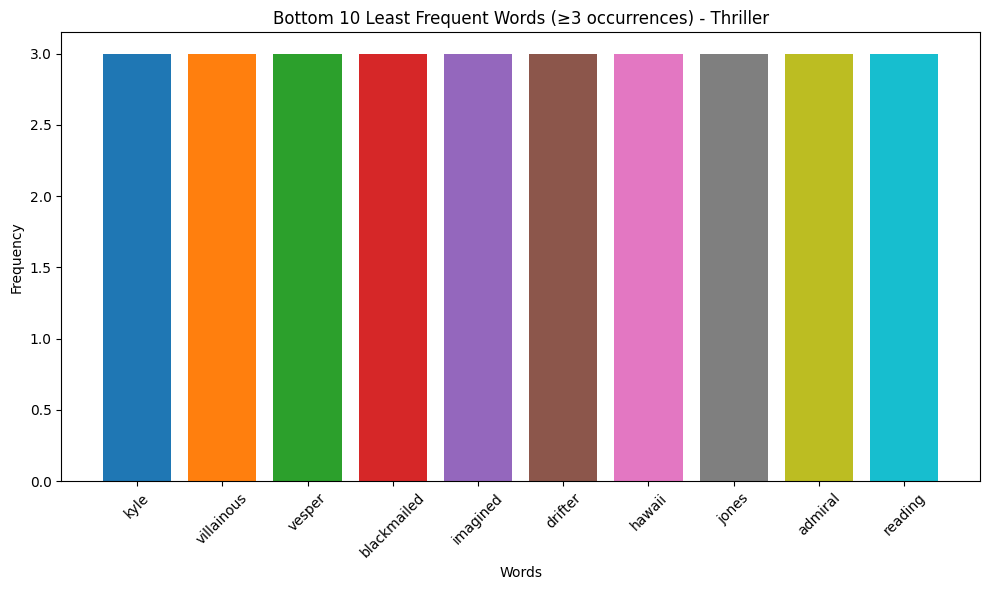

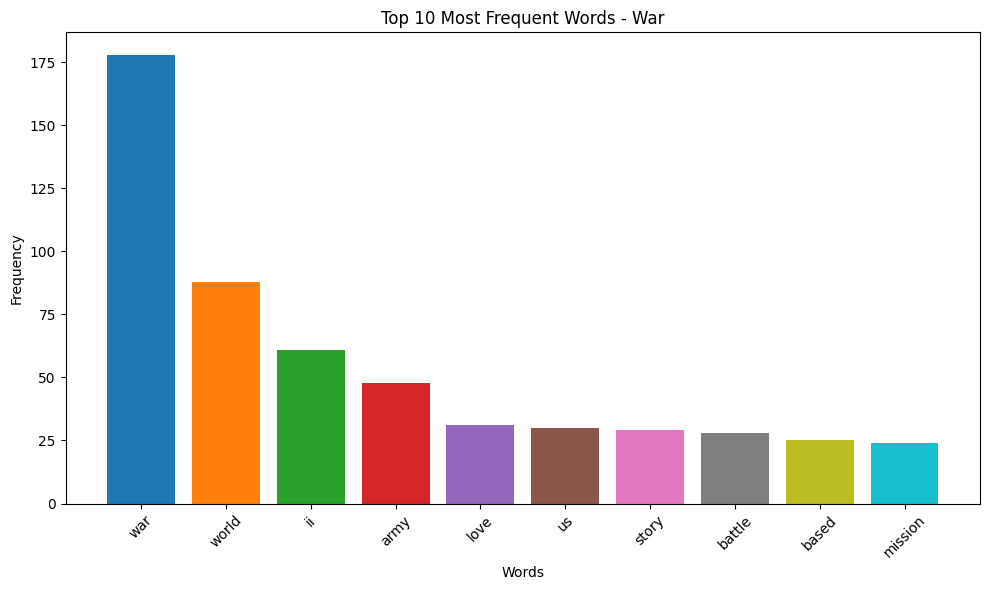

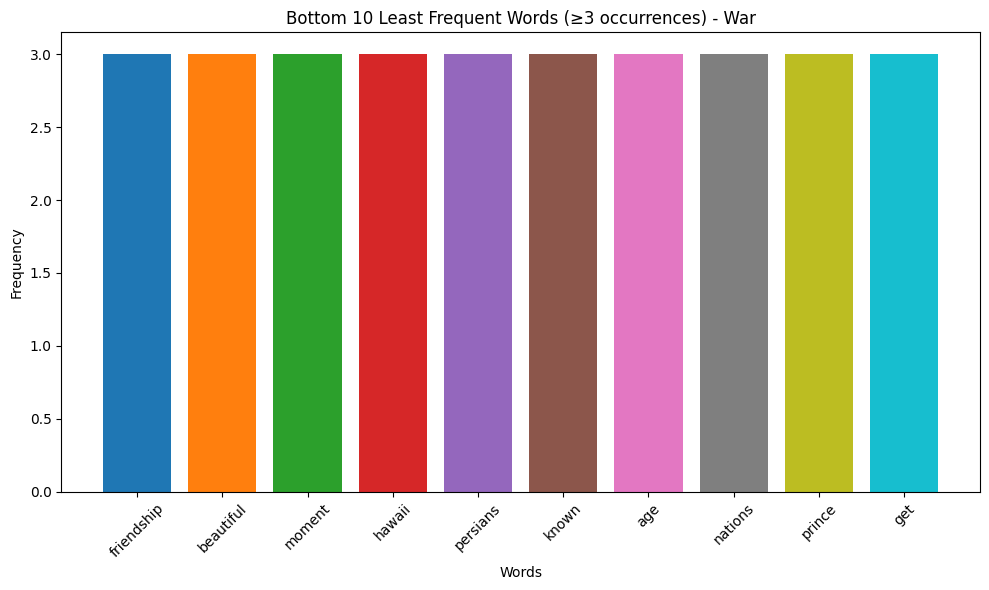

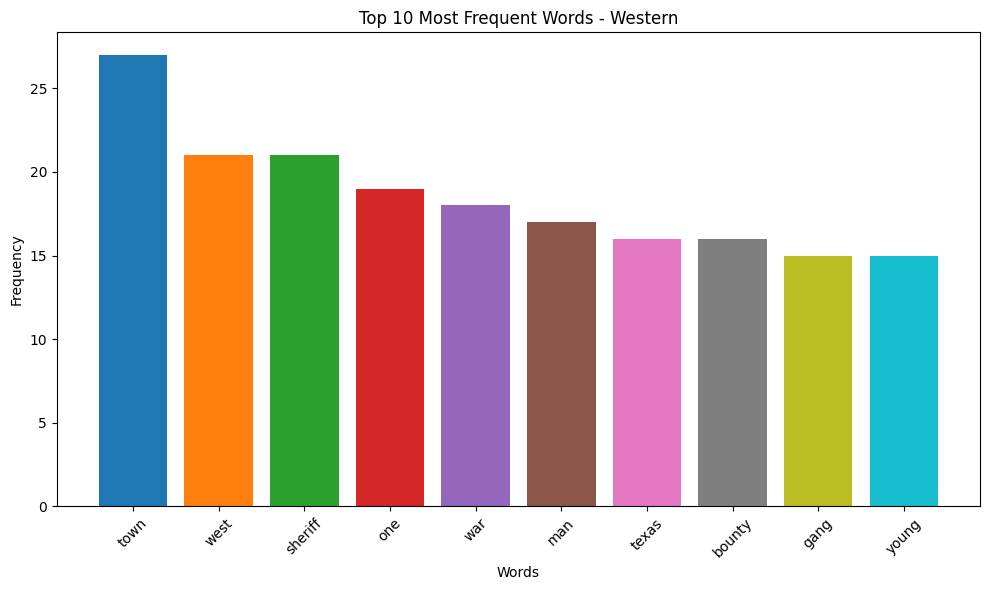

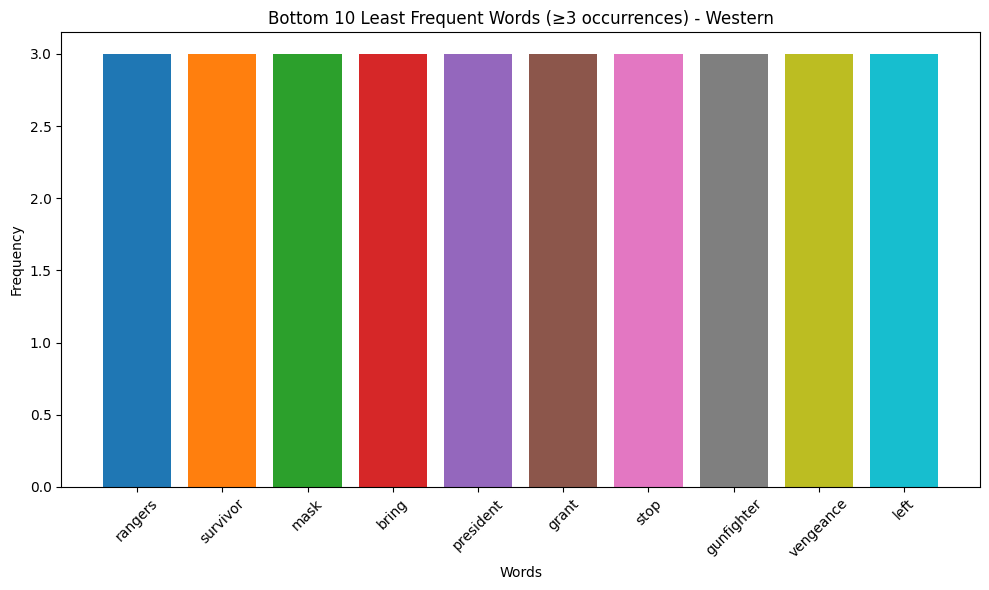

In [62]:
import matplotlib.cm as cm

plt.rcParams["figure.figsize"] = (10, 6)

print("=" * 80)
print("GENERATING VISUALIZATIONS FOR EACH GENRE")
print("=" * 80)

for genre in all_genres:
    word_counts = genre_word_freq[genre]

    if len(word_counts) == 0:
        continue

    # ------------------------
    # TOP 10 MOST FREQUENT
    # ------------------------
    top_10 = word_counts.most_common(10)
    top_df = pd.DataFrame(top_10, columns=['Word', 'Frequency'])

    plt.figure()
    colors = cm.tab10(range(len(top_df)))
    plt.bar(top_df['Word'], top_df['Frequency'], color=colors)
    plt.title(f"Top 10 Most Frequent Words - {genre}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ------------------------
    # BOTTOM 10 (freq >= 3)
    # ------------------------
    filtered_words = {w: c for w, c in word_counts.items() if c >= 3}
    sorted_words = sorted(filtered_words.items(), key=lambda x: x[1])
    bottom_10 = sorted_words[:10] if len(sorted_words) >= 10 else sorted_words

    if bottom_10:
        bottom_df = pd.DataFrame(bottom_10, columns=['Word', 'Frequency'])

        plt.figure()
        colors = cm.tab10(range(len(bottom_df)))
        plt.bar(bottom_df['Word'], bottom_df['Frequency'], color=colors)
        plt.title(f"Bottom 10 Least Frequent Words (≥3 occurrences) - {genre}")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## **Task 6 - Genre-Indicative Words Using TF-IDF**

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

print("=" * 80)
print("GENRE-INDICATIVE WORDS ANALYSIS USING TF-IDF + LOGISTIC REGRESSION")
print("=" * 80)

# Use the TF-IDF matrix already computed
X_tfidf = tfidf_matrix.toarray()
feature_names = tfidf.get_feature_names_out()

# Store results for each genre
genre_indicative_words = {}

# Train a logistic regression model for each genre
for idx, genre in enumerate(all_genres):
    # Get binary labels for this genre
    y_genre = genre_labels[:, idx]
    
    # Train logistic regression with balanced class weights
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr_model.fit(X_tfidf, y_genre)
    
    # Get feature coefficients (weights)
    coefficients = lr_model.coef_[0]
    
    # Get top 10 words with highest positive weights
    top_indices = coefficients.argsort()[-10:][::-1]
    top_words = [(feature_names[i], coefficients[i]) for i in top_indices]
    
    genre_indicative_words[genre] = top_words
    
    # Display results
    print(f"\n{'=' * 80}")
    print(f"GENRE: {genre}")
    print(f"{'=' * 80}")
    print(f"\nTop 10 Most Indicative Words (by TF-IDF weight):")
    print(f"{'-' * 80}")
    
    for rank, (word, weight) in enumerate(top_words, 1):
        print(f"{rank:2d}. {word:20s} (weight: {weight:8.4f})")

    # Provide interpretation
    print(f"\n{'-' * 80}")
    print(f"INTERPRETATION:")
    print(f"{'-' * 80}")

    # Genre-specific interpretations
    if genre == 'Action':
        print("The top indicators for Action films revolve around roles like 'agent', 'cop',")
        print("and 'assassin', alongside terms like 'mission', 'martial', 'revenge', and 'fight',")
        print("reflecting the genre's emphasis on combat, law enforcement, and high-stakes pursuits.")
    elif genre == 'Adventure':
        print("Adventure films are strongly marked by the word 'adventure' itself, along with")
        print("terms like 'bond', 'hero', 'magic', 'jungle', 'marvel', and 'chase', capturing")
        print("the genre's focus on heroic journeys, quests, and action-driven exploration.")
    elif genre == 'Animation':
        print("Animation is identified by words like 'animated', 'animation', and 'adventure',")
        print("alongside animal-related terms such as 'fish', 'cat', 'bird', and 'dog', and")
        print("franchise references like 'shrek', reflecting the genre's family-friendly storytelling.")
    elif genre == 'Comedy':
        print("Comedy films are dominated by the word 'comedy' itself, with supporting terms")
        print("like 'wedding', 'spoof', 'movie', 'guy', and 'hes', pointing to humorous social")
        print("situations, parody, and light-hearted character-driven narratives.")
    elif genre == 'Crime':
        print("Crime films are defined by words like 'murder', 'police', 'crime', 'drug', 'cop',")
        print("'fbi', 'criminal', 'detective', and 'gang', highlighting the genre's focus on")
        print("law enforcement, criminal investigations, and the criminal underworld.")
    elif genre == 'Documentary':
        print("Documentaries are overwhelmingly flagged by the word 'documentary', supported by")
        print("terms like 'film', 'director', 'interviews', 'concert', 'music', and 'filmmakers',")
        print("reflecting their real-world, behind-the-scenes, and investigative nature.")
    elif genre == 'Drama':
        print("Drama films center on words like 'story', 'life', 'love', 'biography', 'war',")
        print("'true', 'wife', and 'father', indicating a focus on personal narratives, family")
        print("relationships, and emotionally grounded, often biographical storytelling.")
    elif genre == 'Family':
        print("Family films are characterized by words like 'adventure', 'dog', 'boy', 'kids',")
        print("'little', 'christmas', 'summer', 'holiday', and 'animation', reflecting wholesome,")
        print("age-appropriate content centered on children, animals, and seasonal themes.")
    elif genre == 'Fantasy':
        print("Fantasy is strongly indicated by words like 'magic', 'evil', 'witch', 'vampire',")
        print("'world', 'powers', 'king', 'werewolf', and 'dragon', highlighting the genre's")
        print("reliance on supernatural beings, magical systems, and mythical world-building.")
    elif genre == 'Fiction':
        print("Science Fiction is marked by futuristic and cosmic terms: 'future', 'alien',")
        print("'dystopia', 'space', 'earth', 'planet', 'time', 'travel', 'robot', and 'superhero',")
        print("reflecting themes of technology, space exploration, and speculative futures.")
    elif genre == 'Foreign':
        print("Foreign films are identified by proper nouns and culturally specific terms such as")
        print("'gandhi', 'detroit', 'ronnie', 'romeo', 'wordsworth', and 'mccain', alongside words")
        print("like 'son', 'girl', and 'beautiful', suggesting diverse international narratives.")
    elif genre == 'History':
        print("Historical films are dominated by 'war' as the top indicator, followed by 'story',")
        print("'biography', 'british', 'army', 'world', 'assassination', 'true', 'china', and")
        print("'queen', reflecting a focus on real events, military history, and prominent figures.")
    elif genre == 'Horror':
        print("Horror is clearly defined by words like 'horror', 'vampire', 'evil', 'supernatural',")
        print("'zombie', 'terror', 'killer', 'dead', 'nightmare', and 'monster', directly capturing")
        print("the genre's reliance on fear, death, and supernatural threats.")
    elif genre == 'Movie':
        print("This category is flagged by a mix of specific proper nouns like 'eduardo', 'missie',")
        print("'willie', and 'jayne', alongside thematic words like 'christmas', 'spy', 'british',")
        print("and 'hurricane', suggesting a broad or miscellaneous grouping of TV/film productions.")
    elif genre == 'Music':
        print("Music films are overwhelmingly identified by 'musical' and 'music' as the top terms,")
        print("followed by 'dance', 'singer', 'rock', 'concert', 'band', 'show', 'pop', and 'dancer',")
        print("directly reflecting the genre's focus on performance, artists, and the music industry.")
    elif genre == 'Mystery':
        print("Mystery films are defined by investigative terms: 'detective', 'murder', 'investigation',")
        print("'killer', 'mysterious', 'truth', 'obsession', 'clues', 'mystery', and 'murdered',")
        print("highlighting the genre's core focus on crime-solving and uncovering hidden truths.")
    elif genre == 'Romance':
        print("Romance is overwhelmingly indicated by 'love' as the top term, supported by 'romance',")
        print("'romantic', 'marriage', 'woman', 'life', 'falls', 'women', 'heart', and 'relationship',")
        print("reflecting the genre's emphasis on emotional bonds, courtship, and relationships.")
    elif genre == 'Science':
        print("Science Fiction shares its top indicators with the Fiction genre: 'future', 'alien',")
        print("'dystopia', 'space', 'earth', 'planet', 'time', 'travel', 'robot', and 'superhero',")
        print("pointing to speculative technology, extraterrestrial life, and futuristic societies.")
    elif genre == 'TV':
        print("The TV category shares its top indicators with the Movie genre, including proper nouns")
        print("like 'eduardo', 'missie', 'willie', and 'jayne', plus words like 'christmas', 'spy',")
        print("'british', and 'hurricane', suggesting overlap with general TV film productions.")
    elif genre == 'Thriller':
        print("Thriller films are flagged by high-tension words: 'murder', 'killer', 'secret',")
        print("'assassin', 'agent', 'police', 'nightmare', 'hostage', 'thriller', and 'revenge',")
        print("capturing the genre's focus on danger, deception, and psychological suspense.")
    elif genre == 'War':
        print("War films are dominated by 'war' and 'army' as the top two terms, followed by 'ii',")
        print("'vietnam', 'soldiers', 'battle', 'resistance', 'mission', 'pilot', and 'officer',")
        print("directly reflecting the genre's portrayal of military conflict and wartime experience.")
    elif genre == 'Western':
        print("Westerns are unmistakably identified by frontier terms: 'west', 'gunslinger', 'bounty',")
        print("'sheriff', 'outlaw', 'civil', 'town', 'horse', 'texas', and 'ranch', capturing the")
        print("genre's iconic setting of the American frontier and its lawless characters.")


GENRE-INDICATIVE WORDS ANALYSIS USING TF-IDF + LOGISTIC REGRESSION

GENRE: Action

Top 10 Most Indicative Words (by TF-IDF weight):
--------------------------------------------------------------------------------
 1. agent                (weight:   2.9561)
 2. cop                  (weight:   2.9290)
 3. assassin             (weight:   2.8646)
 4. hero                 (weight:   2.7368)
 5. mission              (weight:   2.5411)
 6. martial              (weight:   2.4823)
 7. revenge              (weight:   2.3008)
 8. cia                  (weight:   2.1103)
 9. fight                (weight:   2.0821)
10. arts                 (weight:   2.0815)

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------
The top indicators for Action films revolve around roles like 'agent', 'cop',
and 'assassin', alongside terms like 'mission', 'martial', 'revenge', and 'fight',
reflect

GENERATING VISUALIZATIONS FOR GENRE-INDICATIVE WORDS


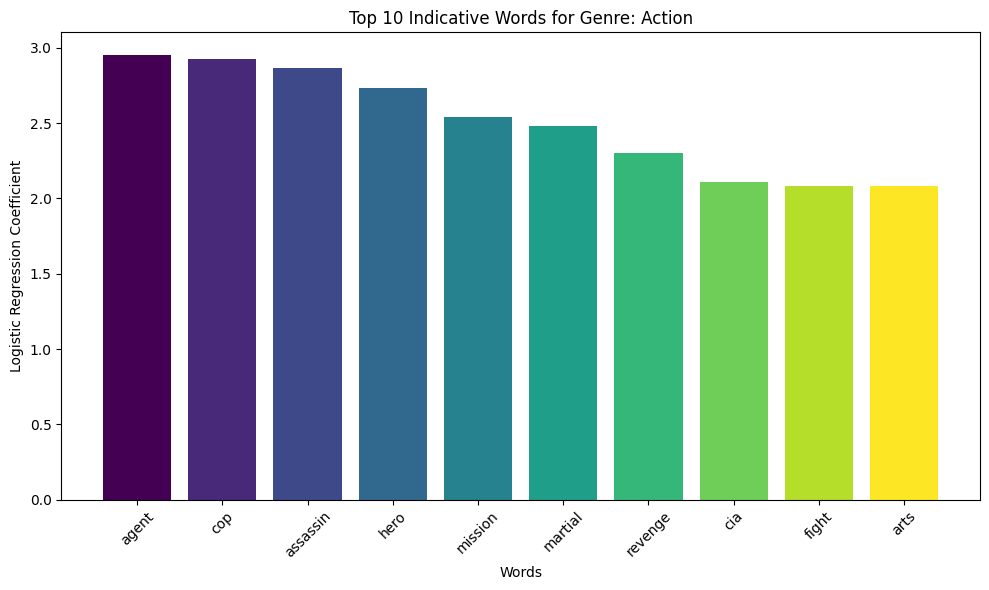

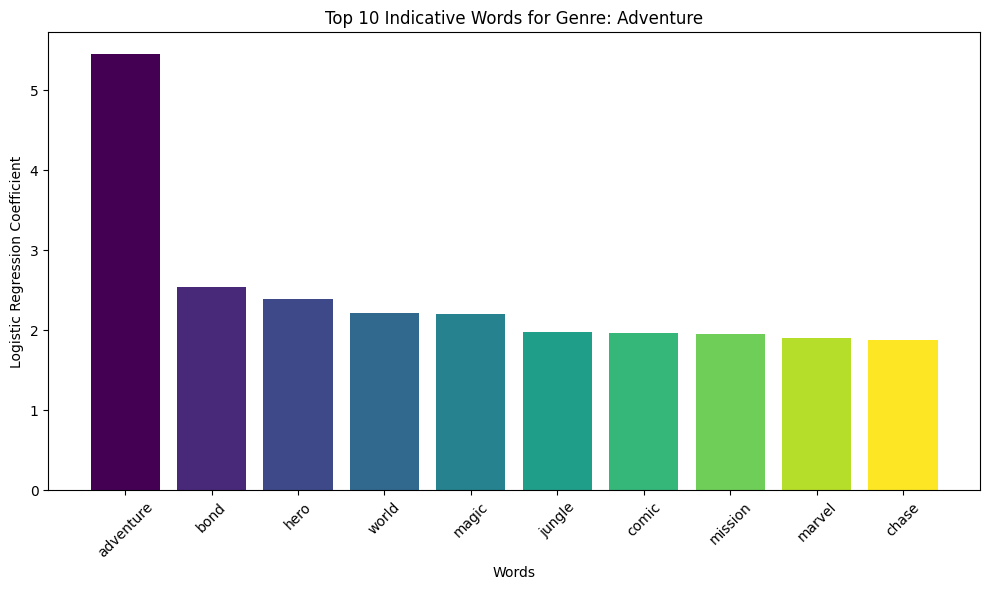

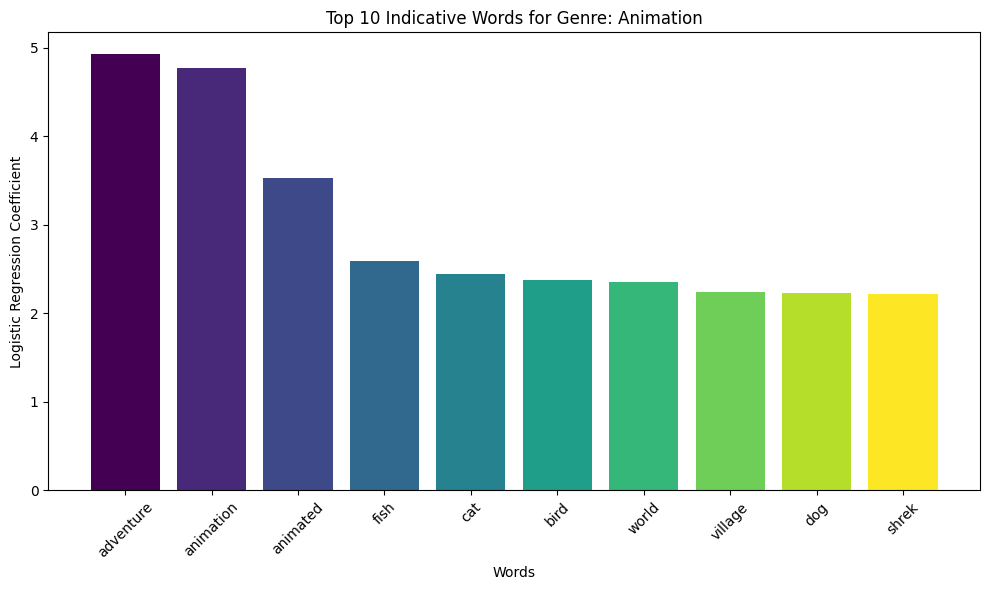

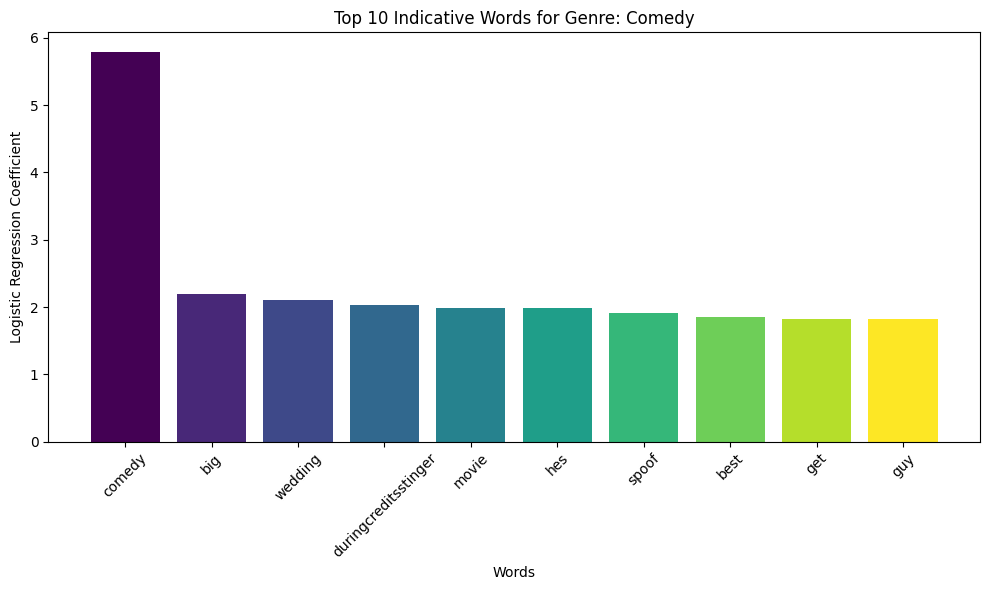

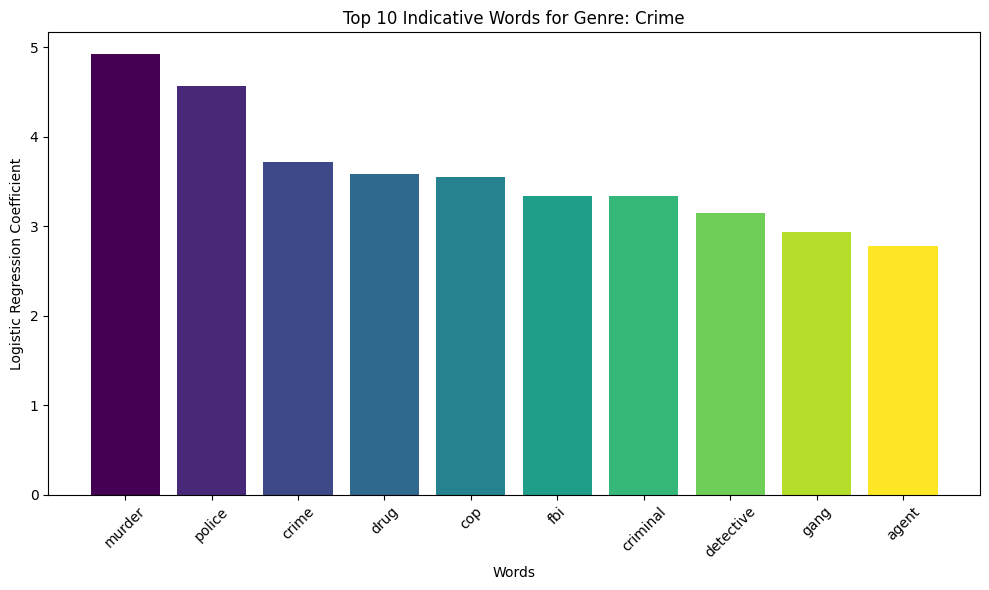

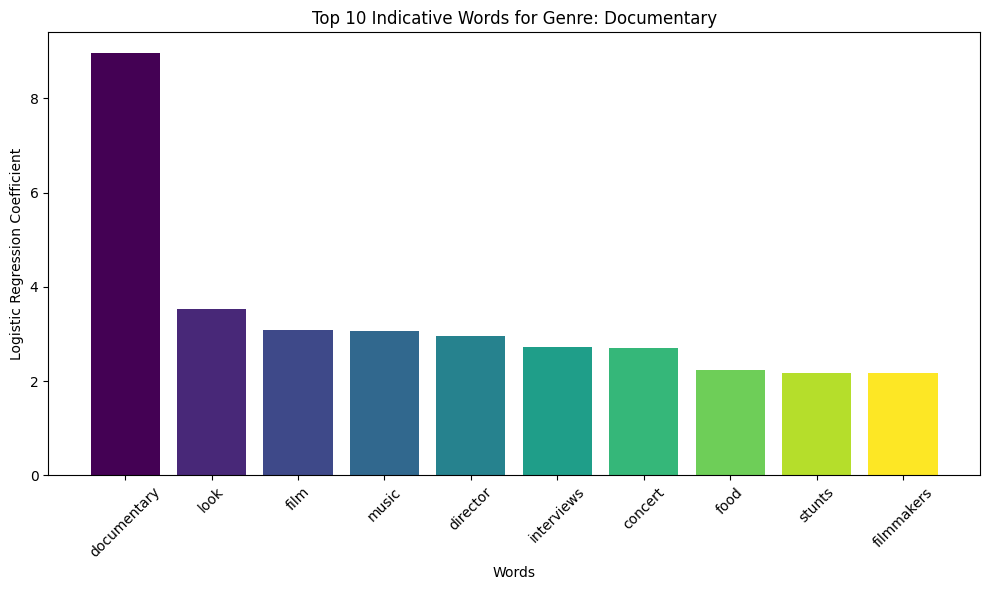

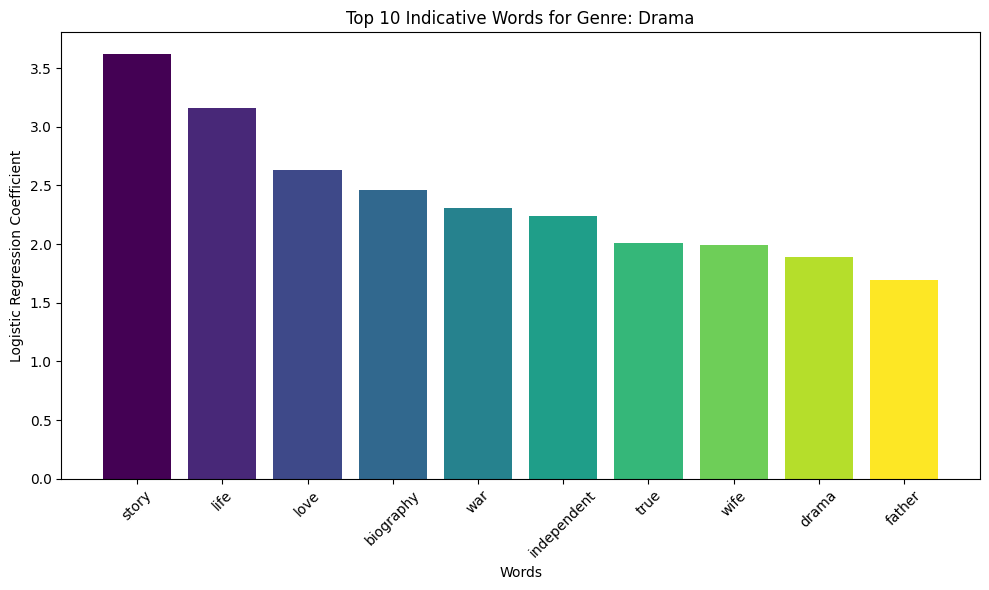

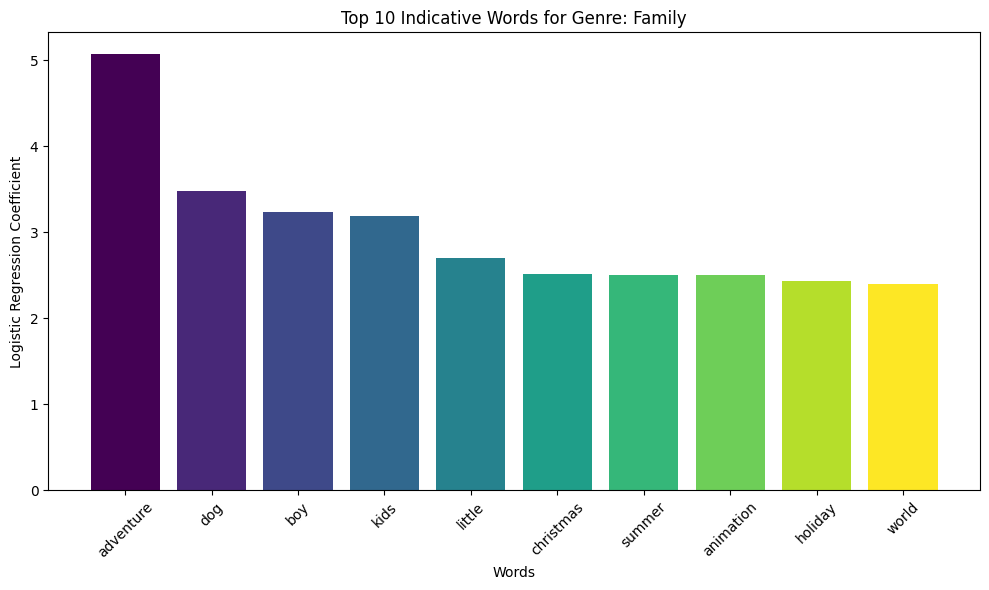

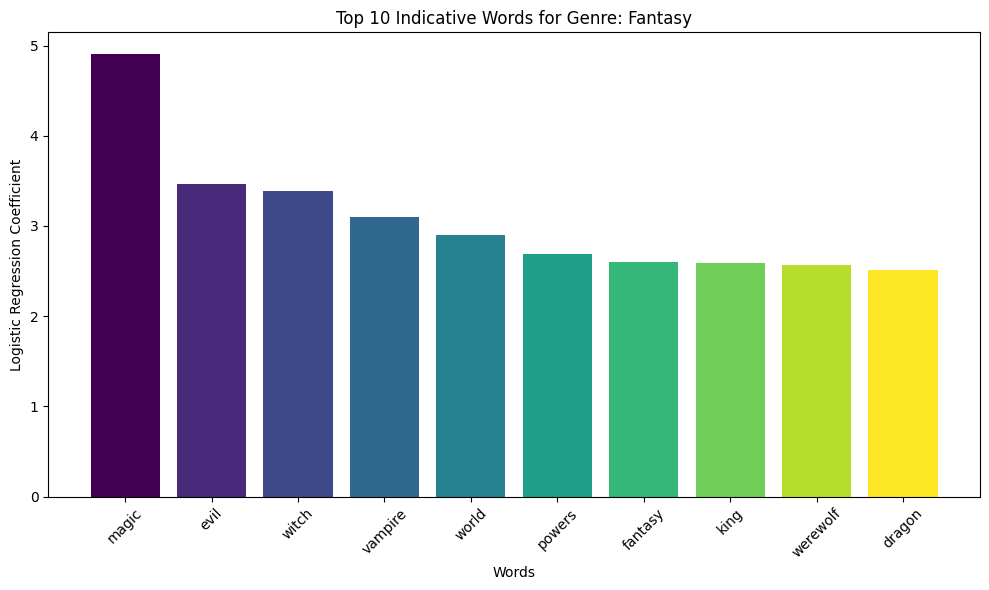

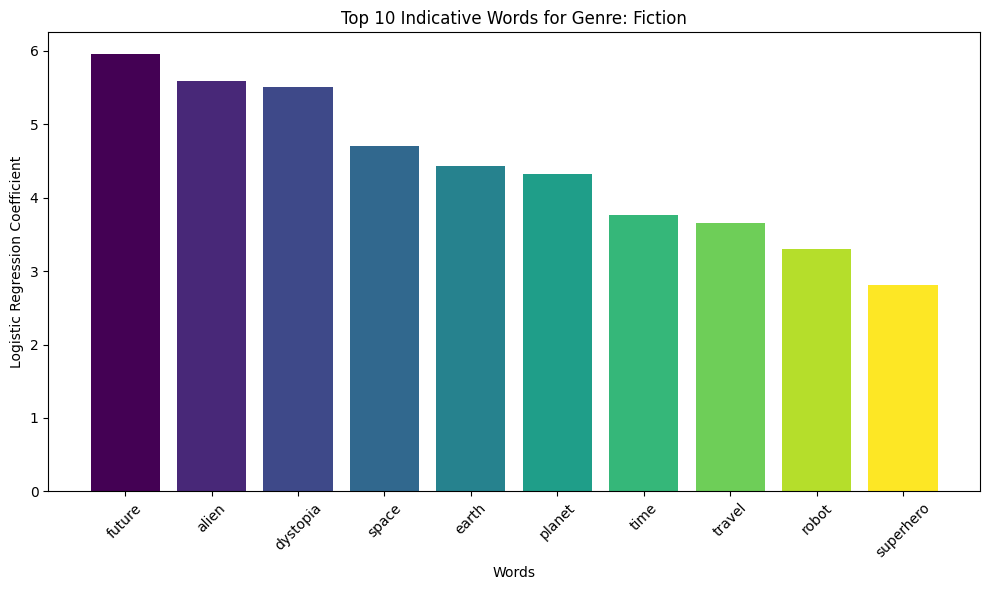

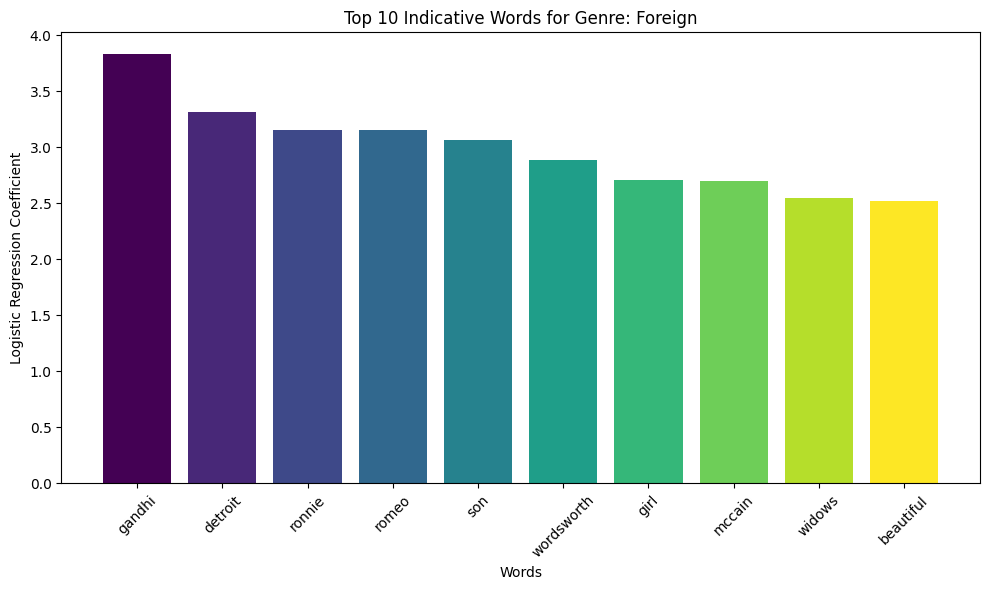

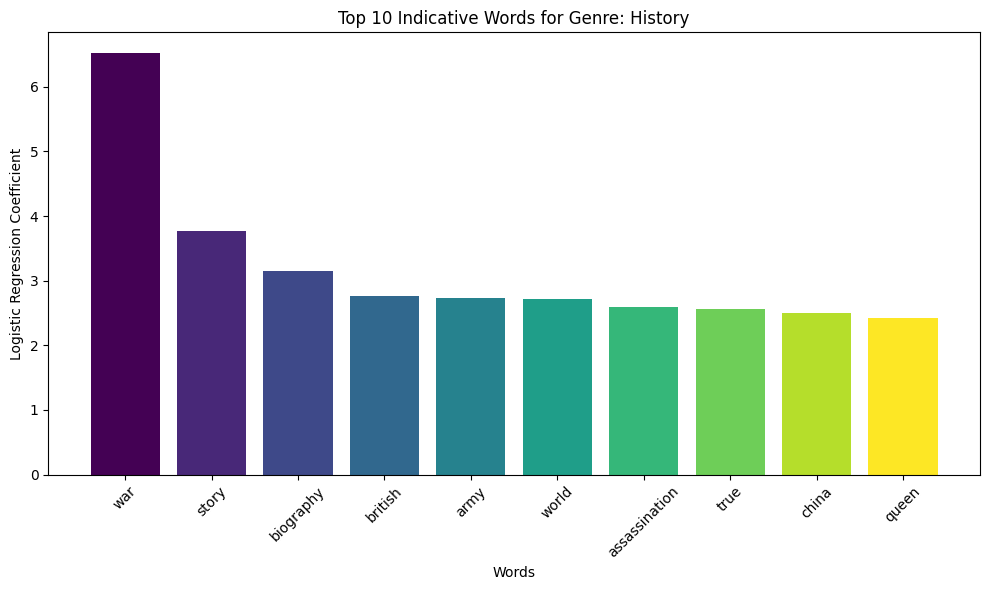

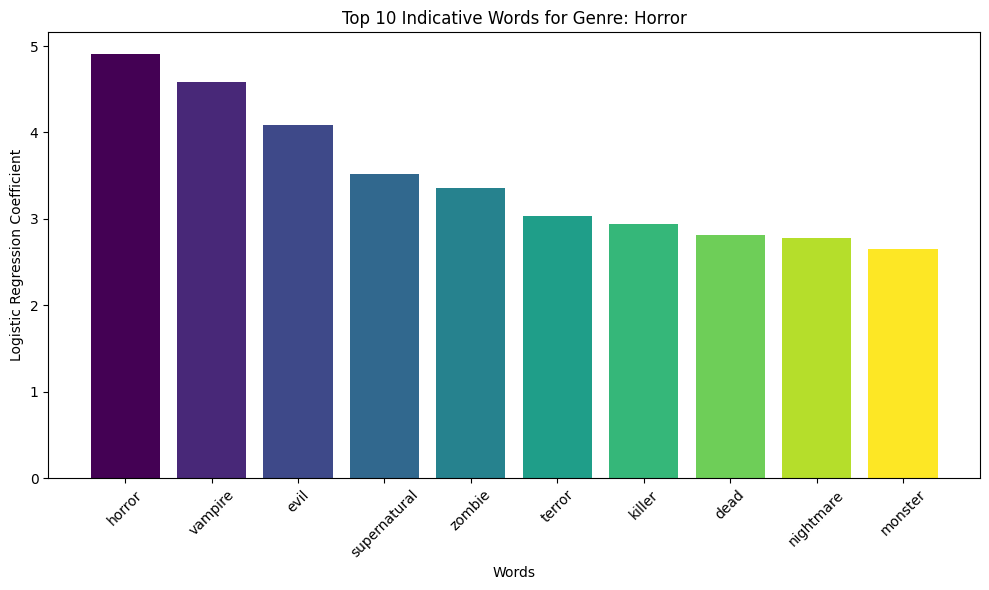

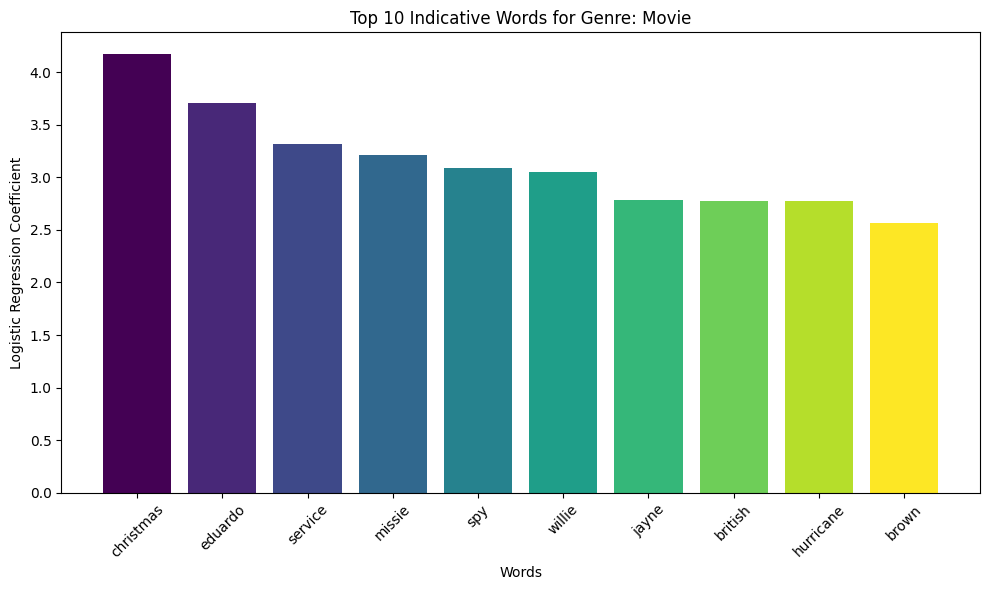

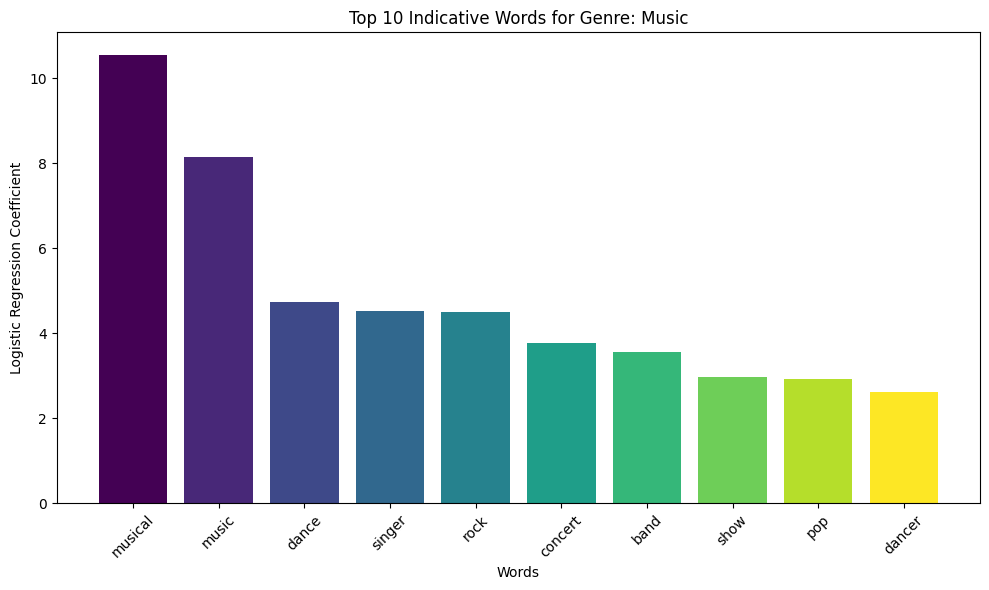

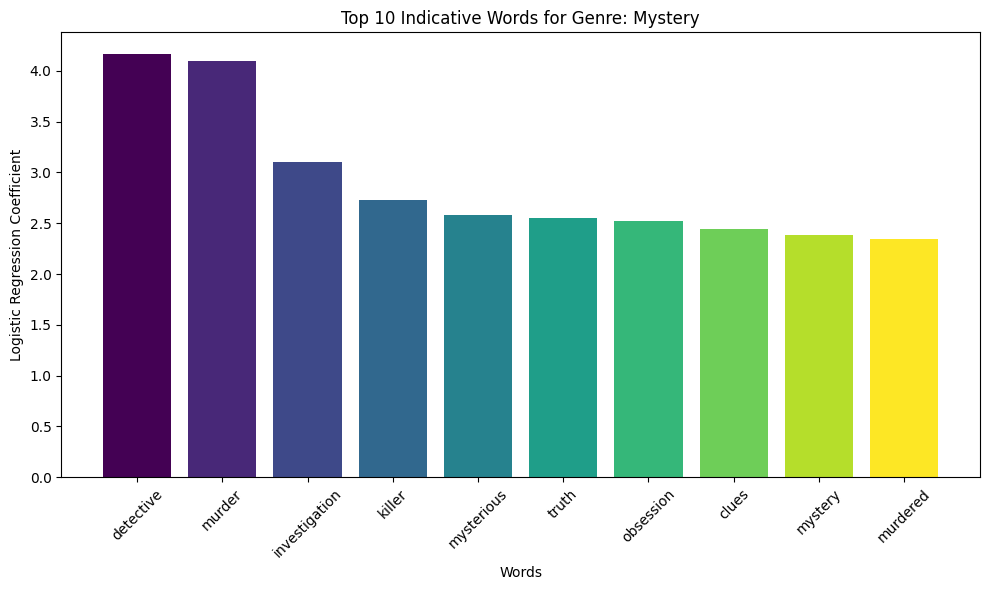

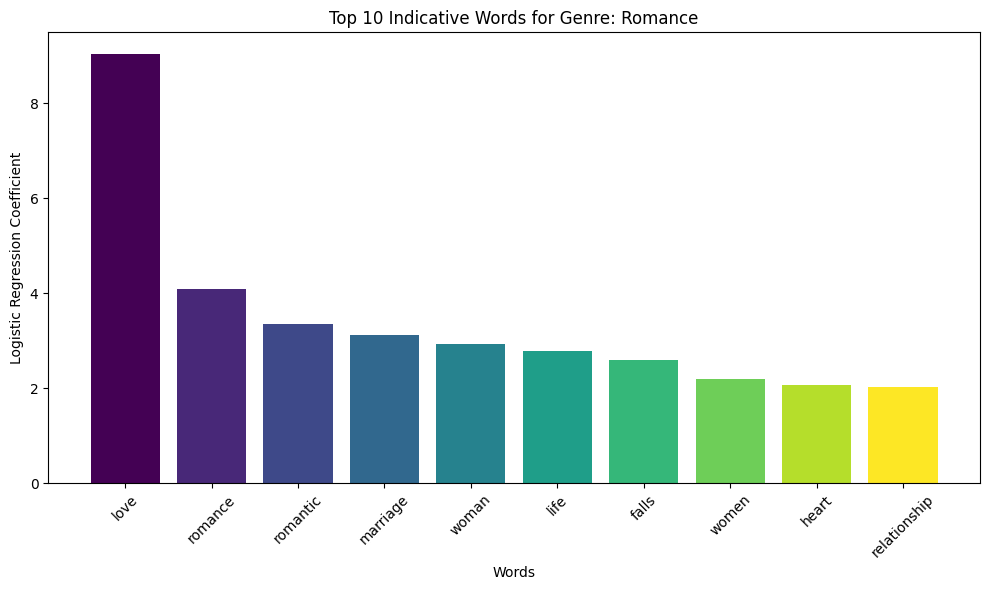

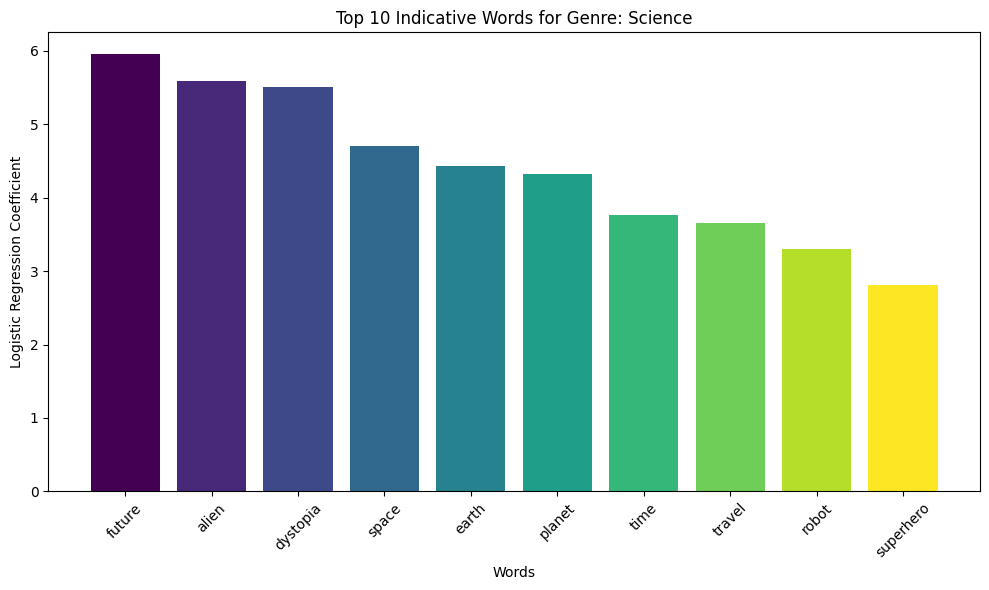

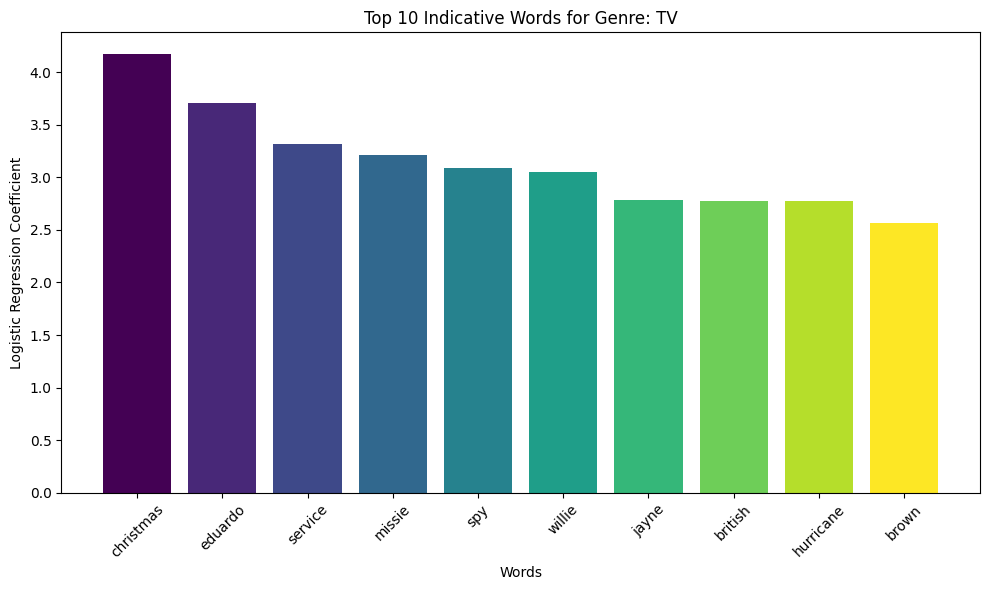

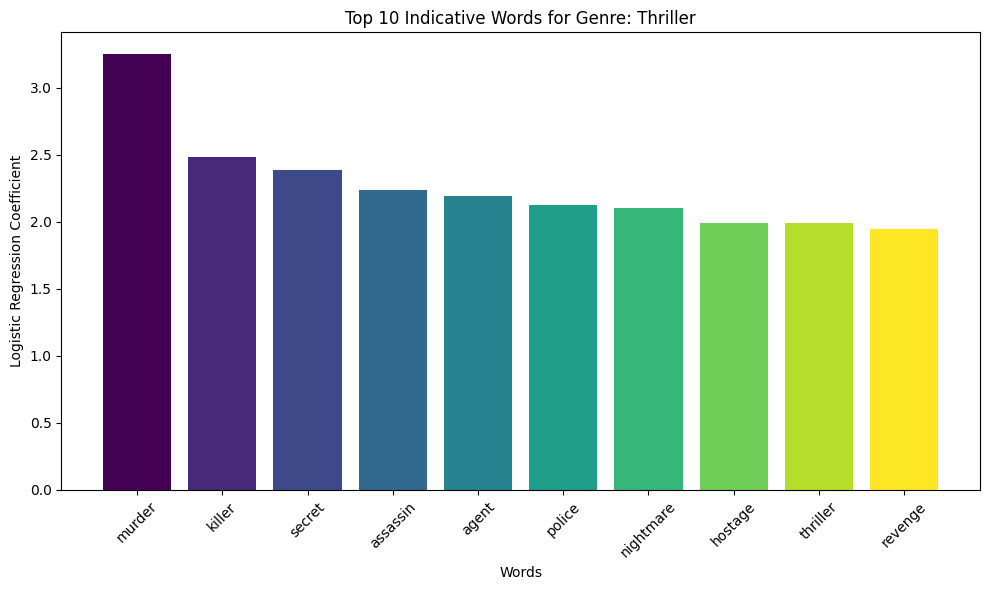

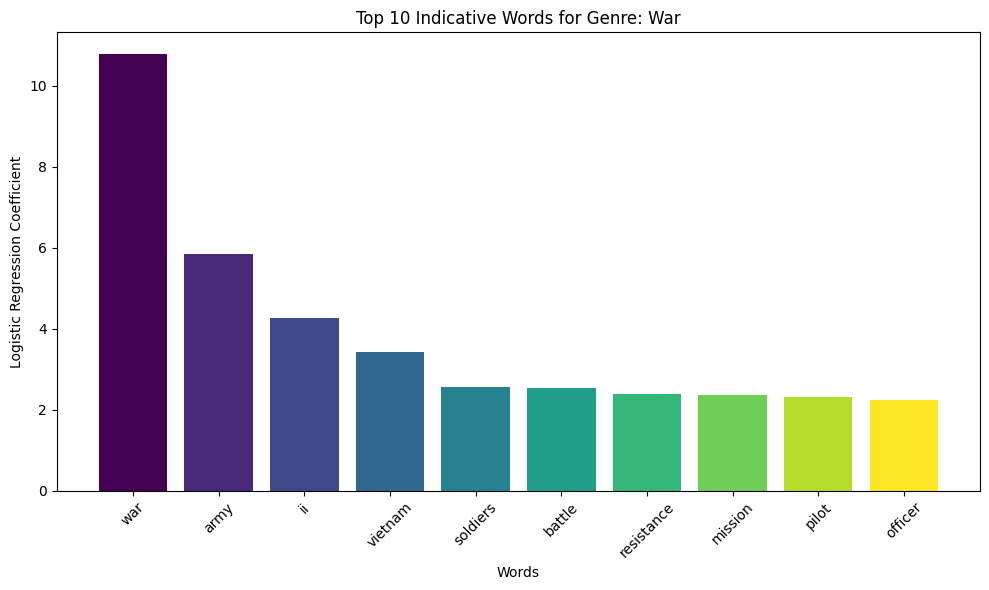

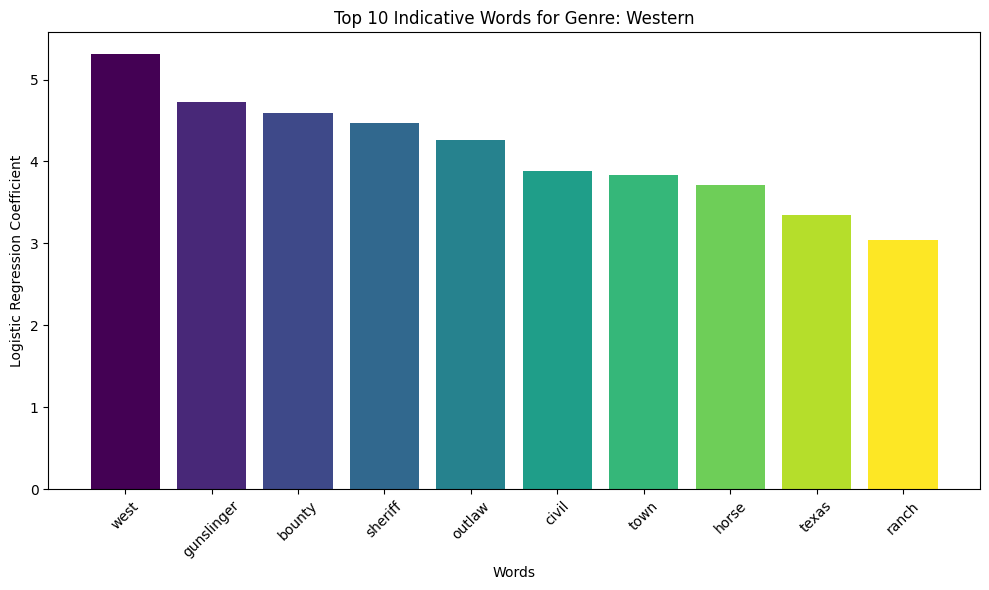


Visualization Complete.


In [64]:
plt.rcParams["figure.figsize"] = (10, 6)

print("=" * 80)
print("GENERATING VISUALIZATIONS FOR GENRE-INDICATIVE WORDS")
print("=" * 80)

# Use existing TF-IDF matrix and feature names
X_tfidf = tfidf_matrix.toarray()
feature_names = tfidf.get_feature_names_out()

for idx, genre in enumerate(all_genres):

    y_genre = genre_labels[:, idx]

    # Train logistic regression
    lr_model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )

    lr_model.fit(X_tfidf, y_genre)

    coefficients = lr_model.coef_[0]

    # Get top 10 most indicative words
    top_indices = np.argsort(coefficients)[-10:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_weights = [coefficients[i] for i in top_indices]

    # Create bar plot with colors
    plt.figure()
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_words)))
    plt.bar(top_words, top_weights, color=colors)
    plt.title(f"Top 10 Indicative Words for Genre: {genre}")
    plt.xlabel("Words")
    plt.ylabel("Logistic Regression Coefficient")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\nVisualization Complete.")


--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------
Westerns are unmistakably identified by frontier terms: 'west', 'gunslinger', 'bounty',
'sheriff', 'outlaw', 'civil', 'town', 'horse', 'texas', and 'ranch', capturing the
genre's iconic setting of the American frontier and its lawless characters.

ANALYSIS COMPLETE
